# **Information**

1. Run the notebook on **Google Colab**
2. I dropped one more feature *exterior_color* because the information is already present in *listing_color* feature
3. The target **price** outliers are kept in the data to make the models more robust
4. Applied **log** transformation to the **price**
5. Stratified splitting of outliers into the train, val and test datasets

# **Import libraries**

In [3]:
# Import all the necessary libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

from category_encoders import TargetEncoder, BinaryEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score, brier_score_loss, roc_auc_score, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error

In [4]:
# Reference article: https://towardsdatascience.com/how-to-calculate-roc-auc-score-for-regression-models-c0be4fdf76bb
# Code slightly modified to run faster
# The score helps us understand how well the model ranks a bigger value higher than a smaller value
def regression_roc_auc_score(y_true, y_pred):
  """
  Computes Regression-ROC-AUC-score.
  
  Parameters:
  ----------
  y_true: array-like of shape (n_samples,). Binary or continuous target variable.
  y_pred: array-like of shape (n_samples,). Target scores.
  
  Returns:
  -------
  rroc: float. Regression-ROC-AUC-score.
  """
  
  import numpy as np
  import itertools
    
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  n_ele = len(y_true)

  num_pairs = 0
  num_same_sign = 0

  for i in range(n_ele - 1):
    diff_true_pred = (y_true[i+1:] - y_true[i]) * (y_pred[i+1:] - y_pred[i])
    diff_pred = y_pred[i+1:] - y_pred[i]
    num_same_sign += (diff_true_pred > 0).sum()
    num_same_sign += (diff_pred == 0).sum()/2
    num_pairs += n_ele - 1 - i
    num_pairs -= ((y_true[i+1:] - y_true[i]) == 0).sum()
  
  return num_same_sign/num_pairs

# **Load the dataset**

In [5]:
!wget -O used_cars_2021.csv "https://www.dropbox.com/s/8j1pad6zjmu8alz/used_cars_data_2021.csv?dl=0"

--2023-04-27 23:12:14--  https://www.dropbox.com/s/8j1pad6zjmu8alz/used_cars_data_2021.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8j1pad6zjmu8alz/used_cars_data_2021.csv [following]
--2023-04-27 23:12:14--  https://www.dropbox.com/s/raw/8j1pad6zjmu8alz/used_cars_data_2021.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb0df3ab772ce408749d452dfe6.dl.dropboxusercontent.com/cd/0/inline/B7Dc47kOU5A43OWZJ4uNEd3q4W-6TVWA2v5beYf8yJvIWnLgO5-DHQNAa2vtiJGXFdB47RuJdIs-B-xlwPMeQD3tYnQK5Jn1HjTYtneqn3iZnQvLo96T1uPySvL6vsLXMVIQMm6uck-EIEniyYFp8SFZXuGLrSMKj5Kb9H32DulqVA/file# [following]
--2023-04-27 23:12:14--  https://ucb0df3ab772ce408749d452dfe6.dl.dropboxusercontent.com/cd/0/inline/B7Dc47kOU5A43OWZJ4uNEd3q4W-6TVWA2v5beYf8yJvIWnLgO5-DHQNAa2vtiJGXFdB47R

In [6]:
used_cars_df = pd.read_csv("used_cars_2021.csv")

/var/folders/yy/fwtx69113sj4wmls17f4fp640000gn/T/ipykernel_1759/1988718333.py:1: DtypeWarning: Columns (3,12,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  used_cars_df = pd.read_csv("used_cars_2021.csv")


In [7]:
# Brief information about the data
used_cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176528 entries, 0 to 176527
Data columns (total 67 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               176528 non-null  int64  
 1   vin                      176528 non-null  object 
 2   back_legroom             138791 non-null  object 
 3   bed                      66 non-null      object 
 4   bed_height               7471 non-null    object 
 5   bed_length               7471 non-null    object 
 6   body_type                166727 non-null  object 
 7   cabin                    511 non-null     object 
 8   city                     176528 non-null  object 
 9   city_fuel_economy        114913 non-null  float64
 10  combine_fuel_economy     0 non-null       float64
 11  daysonmarket             176528 non-null  int64  
 12  dealer_zip               176528 non-null  object 
 13  description              167886 non-null  object 
 14  engi

In [8]:
used_cars_df.head()

,Unnamed: 0,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,604,3C4NJDBB9MT516259,38.3 in,NaN,NaN,NaN,SUV / Crossover,NaN,East Hartford,22.0,...,A,Automatic,t93967,Altitude 4WD,NaN,4WD,Four-Wheel Drive,103.8 in,80 in,2021
1,612,3C4NJDBB5MT500768,38.3 in,NaN,NaN,NaN,SUV / Crossover,NaN,East Hartford,22.0,...,A,Automatic,t93967,Altitude 4WD,NaN,4WD,Four-Wheel Drive,103.8 in,80 in,2021
2,629,3C4NJDBBXMT507232,38.3 in,NaN,NaN,NaN,SUV / Crossover,NaN,East Hartford,22.0,...,A,Automatic,t93967,Altitude 4WD,NaN,4WD,Four-Wheel Drive,103.8 in,80 in,2021
3,642,3C4NJDBB0MT503304,38.3 in,NaN,NaN,NaN,SUV / Crossover,NaN,East Hartford,22.0,...,A,Automatic,t93967,Altitude 4WD,NaN,4WD,Four-Wheel Drive,103.8 in,80 in,2021
4,646,3C4NJDBB9MT516410,38.3 in,NaN,NaN,NaN,SUV / Crossover,NaN,East Hartford,22.0,...,A,Automatic,t93967,Altitude 4WD,NaN,4WD,Four-Wheel Drive,103.8 in,80 in,2021


In [9]:
print(used_cars_df.columns)   # Column names in the dataset
print("\nShape of the dataframe:", used_cars_df.shape)

Index(['Unnamed: 0', 'vin', 'back_legroom', 'bed', 'bed_height', 'bed_length',
       'body_type', 'cabin', 'city', 'city_fuel_economy',
       'combine_fuel_economy', 'daysonmarket', 'dealer_zip', 'description',
       'engine_cylinders', 'engine_displacement', 'engine_type',
       'exterior_color', 'fleet', 'frame_damaged', 'franchise_dealer',
       'franchise_make', 'front_legroom', 'fuel_tank_volume', 'fuel_type',
       'has_accidents', 'height', 'highway_fuel_economy', 'horsepower',
       'interior_color', 'isCab', 'is_certified', 'is_cpo', 'is_new',
       'is_oemcpo', 'latitude', 'length', 'listed_date', 'listing_color',
       'listing_id', 'longitude', 'main_picture_url', 'major_options',
       'make_name', 'maximum_seating', 'mileage', 'model_name', 'owner_count',
       'power', 'price', 'salvage', 'savings_amount', 'seller_rating', 'sp_id',
       'sp_name', 'theft_title', 'torque', 'transmission',
       'transmission_display', 'trimId', 'trim_name',
       'vehicle_d

# **2. Cleaning the dataset**

## 2.1 Convert numerical features from string to float format

In [10]:
# Convert some of the numerical features from str to float

# Numerical features: ['back_legroom' --> need to convert from str to int, 'front_legroom' --> need to convert from str to int,
# 'fuel_tank_volume' --> need to convert from str to int, 'height' --> need to convert from str to int,
# 'length' --> need to convert from str to int, 'maximum_seating' --> need to convert from str to int, 
# 'torque' --> remove the rpm, 'wheelbase' --> need to convert from str to int, 'width' --> need to convert from str to int]

convert_num_features = ['back_legroom', 'front_legroom', 'fuel_tank_volume', 'height', 'length',
                        'maximum_seating', 'torque', 'wheelbase', 'width']

for col in convert_num_features:
  used_cars_df[col] = used_cars_df[col].str.split(' ').str[0]
  used_cars_df[col] = pd.to_numeric(used_cars_df[col], errors = 'coerce')

## 2.2 Convert **major_options** feature

In [11]:
# Convert major_options from list to number of major options
used_cars_df['major_options'] = used_cars_df['major_options'].str.count(',') + 1

## 2.3 Drop features with irrelevant information

In [12]:
# drop the features which do not provide relavant information
drop_columns = []

# dropping the 'year' column because it is just for information and not a feature
drop_columns.append('year') 
# dropping the first two columns because it contains index and VIN of the rows which is just for information
drop_columns.append(used_cars_df.columns[0])
drop_columns.append(used_cars_df.columns[1])
# 'listed_date' feature can be dropped because we have information about the 'daysonmarket'
drop_columns.append('listed_date') 
# 'description' feature can be dropped because it mainly contains redundant information present in other features
drop_columns.append('description') 
# 'latitude' and 'longitude' features can be dropped because we already have 'city' information
drop_columns.append('latitude')
drop_columns.append('longitude')
# 'listing_id' can be dropped because that is just an information and not a feature
drop_columns.append('listing_id')
# 'main_picture_url' can be dropped
drop_columns.append('main_picture_url')
# 'sp_id' and 'sp_name' can be dropped because we have 'seller_rating'
drop_columns.append('sp_id')
drop_columns.append('sp_name')
# 'trimId' can be dropped because we have 'trim_name'
drop_columns.append('trimId')
# 'wheel_system' can be dropped because we have 'wheel_system_display'
drop_columns.append('wheel_system')
# 'dealer_zip' can be dropped because we have 'city' information
drop_columns.append('dealer_zip')
# 'transmission' can be removed because we have 'transmission_display' information
drop_columns.append('transmission')
# 'engine_type' and 'engine_cylinders' have the same exact information so the former can be dropped
drop_columns.append('engine_type')
# 'power' can be dropped because we have 'horsepower' information
drop_columns.append('power')
# 'exterior_color' can be dropped because we have more generic 'listing_color' information
drop_columns.append('exterior_color')

print("Number of irrelevant features:", len(drop_columns))
used_cars_df = used_cars_df.drop(drop_columns, axis = 1)

Number of irrelevant features: 18


In [13]:
# 'savings_amount' had only one unique value after outlier handling.
# It is dropped at that stage

In [14]:
# 'features' remaining after dropping the irrelevant features
used_cars_df.columns

Index(['back_legroom', 'bed', 'bed_height', 'bed_length', 'body_type', 'cabin',
       'city', 'city_fuel_economy', 'combine_fuel_economy', 'daysonmarket',
       'engine_cylinders', 'engine_displacement', 'fleet', 'frame_damaged',
       'franchise_dealer', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
       'highway_fuel_economy', 'horsepower', 'interior_color', 'isCab',
       'is_certified', 'is_cpo', 'is_new', 'is_oemcpo', 'length',
       'listing_color', 'major_options', 'make_name', 'maximum_seating',
       'mileage', 'model_name', 'owner_count', 'price', 'salvage',
       'savings_amount', 'seller_rating', 'theft_title', 'torque',
       'transmission_display', 'trim_name', 'vehicle_damage_category',
       'wheel_system_display', 'wheelbase', 'width'],
      dtype='object')

## 2.4 Drop records/features with missing values

Number of records with some value missing:  176528
Number of features with some value missing:  39
Number of features with more than 30% values missing:  19 



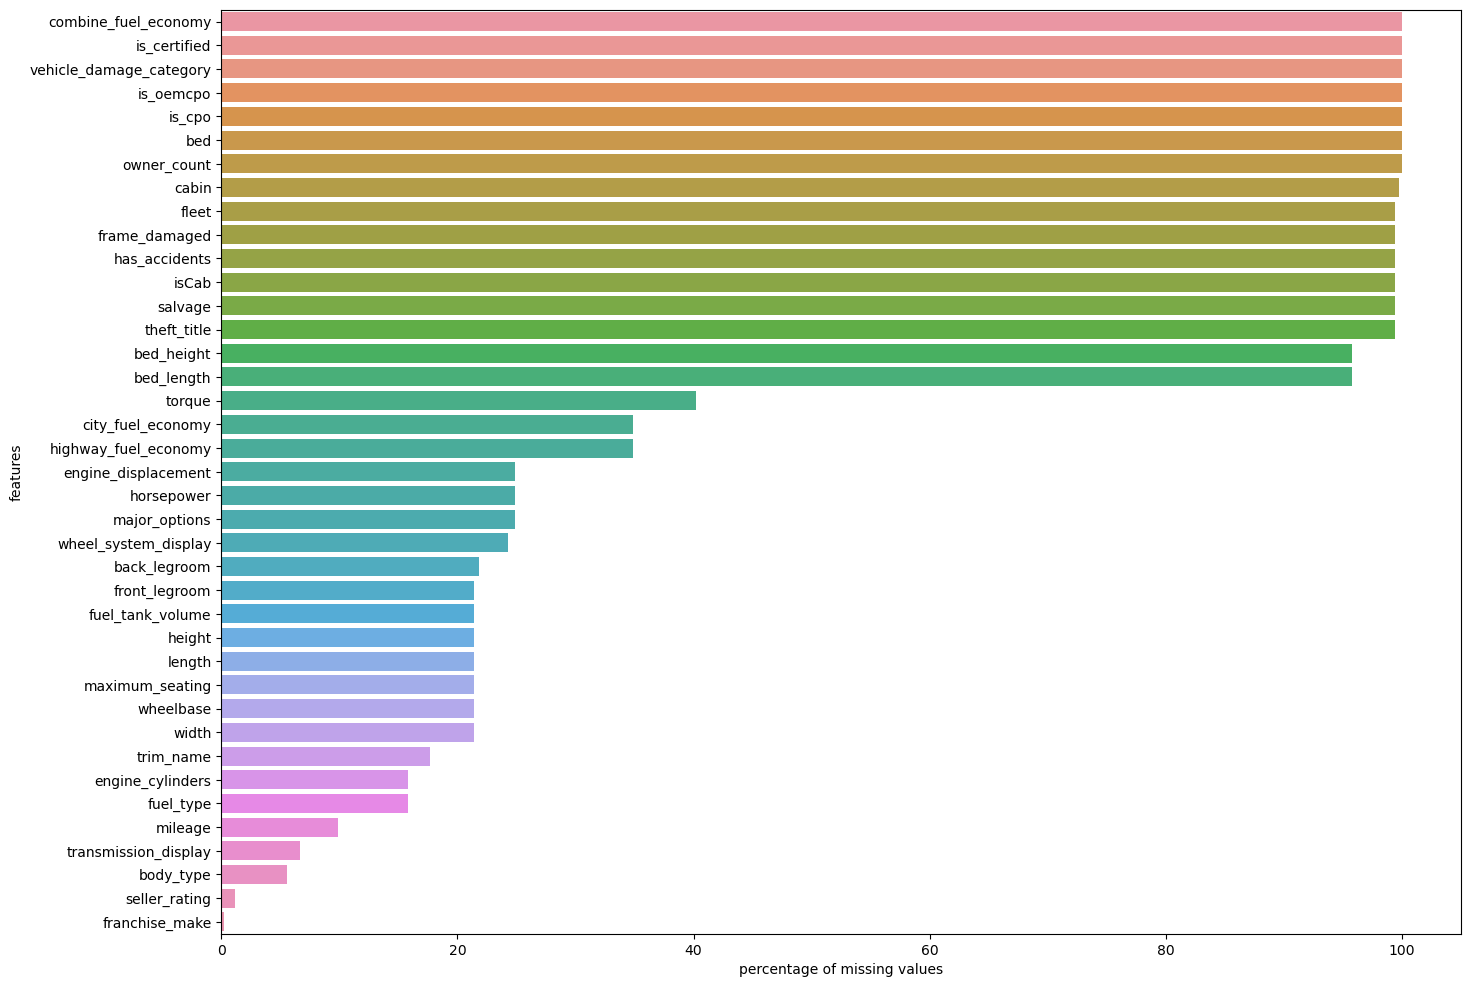

In [15]:
# Number of records with atleast one missing feature value
print("Number of records with some value missing: ", used_cars_df.isnull().any(axis=1).sum())
# All the rows have some missing value, so cannot drop rows

cols_missing_values = {}      # columns with some value missing
cols_missing_30percent = []   # columns with more than 30% values missing

# Percentage of missing values in each column
for col in used_cars_df:
  if used_cars_df[col].isna().sum() * 100 / used_cars_df.shape[0] >= 30:
    cols_missing_30percent.append(col)
  
  if used_cars_df[col].isna().sum() * 100 / used_cars_df.shape[0] > 0:
    cols_missing_values[col] = used_cars_df[col].isna().sum() * 100 / used_cars_df.shape[0]

# Number of features with some value missing
print("Number of features with some value missing: ", len(cols_missing_values))
cols_missing_values = dict(sorted(cols_missing_values.items(), key=lambda x: x[1], reverse=True))

# for col in cols_missing_values.keys():
#   print(col.ljust(30), round(cols_missing_values[col], 2))

plt.figure(figsize = (16, 12))
sns.barplot(y = list(cols_missing_values.keys()), x = list(cols_missing_values.values()), orient = "h")
plt.xlabel('percentage of missing values')
plt.ylabel('features')
# plt.savefig('missing_values.png', format='png', dpi=600)

# Number of features with more than 30% values missing. They can be dropped  
print("Number of features with more than 30% values missing: ", len(cols_missing_30percent), "\n")

used_cars_df = used_cars_df.drop(cols_missing_30percent, axis = 1)

In [16]:
# features 'remaining' after dropping the features with missing values
print(used_cars_df.columns)
print("\nShape of the dataframe:", used_cars_df.shape)

Index(['back_legroom', 'body_type', 'city', 'daysonmarket', 'engine_cylinders',
       'engine_displacement', 'franchise_dealer', 'franchise_make',
       'front_legroom', 'fuel_tank_volume', 'fuel_type', 'height',
       'horsepower', 'interior_color', 'is_new', 'length', 'listing_color',
       'major_options', 'make_name', 'maximum_seating', 'mileage',
       'model_name', 'price', 'savings_amount', 'seller_rating',
       'transmission_display', 'trim_name', 'wheel_system_display',
       'wheelbase', 'width'],
      dtype='object')

Shape of the dataframe: (176528, 30)


# **3. Data preprocessing**

## 3.1 Fill the missing feature values

In [17]:
# Display the features with less than 30% missing values
for col in cols_missing_values.keys():
  if cols_missing_values[col] < 30:
    print(col.ljust(30), round(cols_missing_values[col], 2))

engine_displacement            24.86
horsepower                     24.86
major_options                  24.85
wheel_system_display           24.3
back_legroom                   21.85
front_legroom                  21.4
fuel_tank_volume               21.39
height                         21.39
length                         21.39
maximum_seating                21.39
wheelbase                      21.39
width                          21.39
trim_name                      17.7
engine_cylinders               15.83
fuel_type                      15.81
mileage                        9.88
transmission_display           6.7
body_type                      5.55
seller_rating                  1.2
franchise_make                 0.19


In [18]:
# Less than 25% of the data has missing values, so basic imputations will suffice

# Impute the categorical features using 'mode'
categorical_features = ['wheel_system_display', 'trim_name', 'engine_cylinders', 
                        'fuel_type', 'transmission_display', 'body_type', 'franchise_make']
for col in categorical_features:
  used_cars_df[col] = used_cars_df[col].fillna(used_cars_df[col].mode()[0])


# Impute the numerical features using 'median'
numerical_features = ['seller_rating', 'engine_displacement', 'horsepower', 'back_legroom', 'front_legroom',
                        'fuel_tank_volume', 'height', 'length', 'maximum_seating', 'wheelbase', 'width']
for col in numerical_features:
  used_cars_df[col] = used_cars_df[col].fillna(used_cars_df[col].median())

# 'mileage' default values are '0', so fill the missing values as '0'
used_cars_df['mileage'] = used_cars_df['mileage'].fillna(0)

# 'major_options' missing values can be considered as having no 'major_options', so fill the missing values as '0'
used_cars_df['major_options'] = used_cars_df['major_options'].fillna(0.0)

## 3.2 Outlier handling

Number of rows in the dataset:  176528
Number of rows in the dataset after removing 'mileage' outliers:  172575


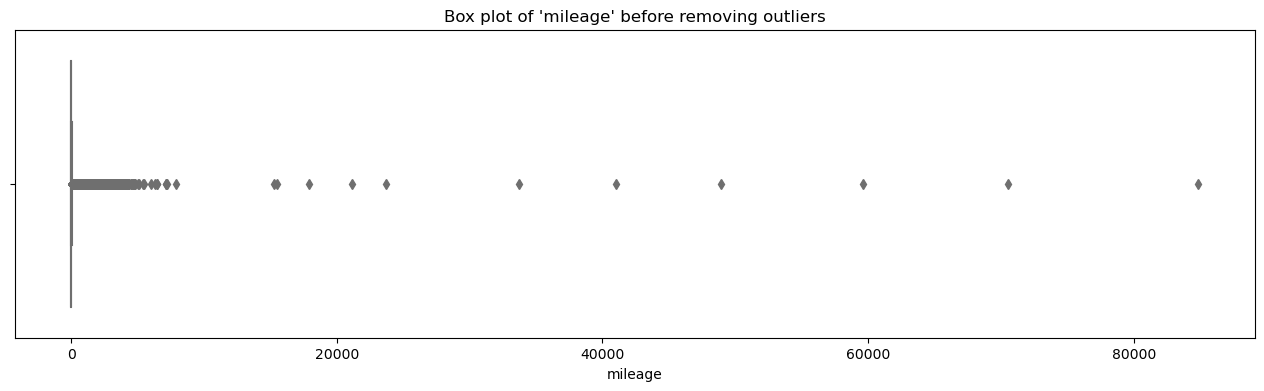

In [19]:
# Remove the rows with target 'price' values as outliers
fig, axs = plt.subplots(1, 1, figsize = (16, 4))


print("Number of rows in the dataset: ", used_cars_df.shape[0])
# box subplot for the 'mileage'
sns.boxplot(ax = axs, x = 'mileage', data = used_cars_df, color = 'skyblue', palette = None);
mileages = used_cars_df["mileage"].to_numpy()
axs.set_title("Box plot of 'mileage' before removing outliers")
# Only 2.2% of the records are dropped, so this is ok to do

# plt.savefig("before_outliers.png", format='png', dpi=600)

q1 = np.percentile(mileages, 25)
q3 = np.percentile(mileages, 75)
upper_limit = q3 + 1.5 * (q3 - q1)
lower_limit = q1 - 1.5 * (q3 - q1)

used_cars_df = used_cars_df.drop(used_cars_df[used_cars_df['mileage'] < lower_limit].index)
used_cars_df = used_cars_df.drop(used_cars_df[used_cars_df['mileage'] > upper_limit].index)
print("Number of rows in the dataset after removing 'mileage' outliers: ", used_cars_df.shape[0])

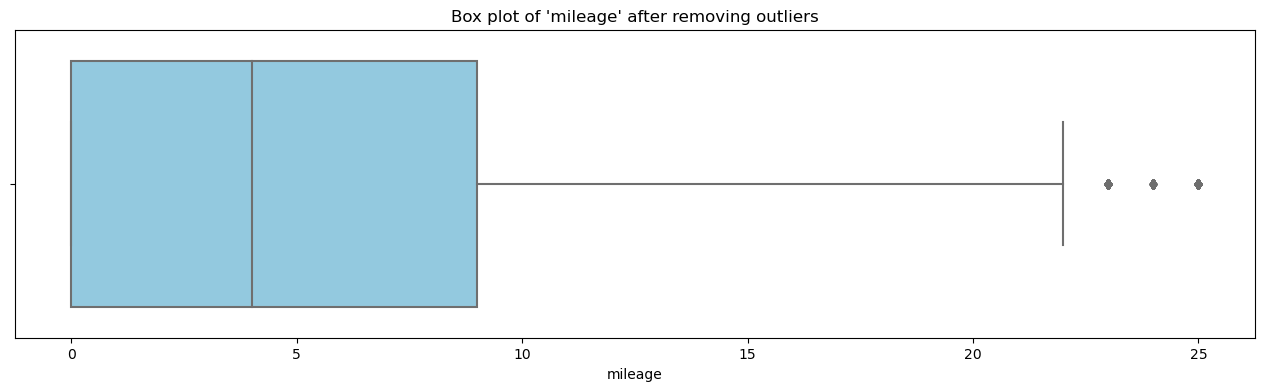

In [20]:
fig, axs = plt.subplots(1, 1, figsize = (16, 4))

sns.boxplot(ax = axs, x = 'mileage', data = used_cars_df, color = 'skyblue', palette = None);
axs.set_title("Box plot of 'mileage' after removing outliers");
# plt.savefig("after_outliers.png", format='png', dpi=600)

In [21]:
# unique values in 'savings_amount'
print("Unique values in 'savings_amount' feature: ", used_cars_df['savings_amount'].nunique())
# there is only 1 unique value in 'savings_amount', so the feature can be dropped
used_cars_df = used_cars_df.drop('savings_amount', axis = 1)

Unique values in 'savings_amount' feature:  1


## 3.3 Splitting the features and target variable

In [22]:
# Separate features and target variable
used_cars_price = used_cars_df[["price"]].copy()
used_cars_features = used_cars_df.copy().drop("price", axis = 1)

used_cars_features.head()

,back_legroom,body_type,city,daysonmarket,engine_cylinders,engine_displacement,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,...,make_name,maximum_seating,mileage,model_name,seller_rating,transmission_display,trim_name,wheel_system_display,wheelbase,width
0,38.3,SUV / Crossover,East Hartford,7,I4,2400.0,True,Jeep,41.8,13.5,...,Jeep,5.0,0.0,Compass,4.377778,Automatic,Altitude 4WD,Four-Wheel Drive,103.8,80.0
1,38.3,SUV / Crossover,East Hartford,24,I4,2400.0,True,Jeep,41.8,13.5,...,Jeep,5.0,0.0,Compass,4.377778,Automatic,Altitude 4WD,Four-Wheel Drive,103.8,80.0
2,38.3,SUV / Crossover,East Hartford,20,I4,2400.0,True,Jeep,41.8,13.5,...,Jeep,5.0,0.0,Compass,4.377778,Automatic,Altitude 4WD,Four-Wheel Drive,103.8,80.0
3,38.3,SUV / Crossover,East Hartford,12,I4,2400.0,True,Jeep,41.8,13.5,...,Jeep,5.0,0.0,Compass,4.377778,Automatic,Altitude 4WD,Four-Wheel Drive,103.8,80.0
4,38.3,SUV / Crossover,East Hartford,7,I4,2400.0,True,Jeep,41.8,13.5,...,Jeep,5.0,0.0,Compass,4.377778,Automatic,Altitude 4WD,Four-Wheel Drive,103.8,80.0


# **4. Data Visualization and Insights**

## 4.0 Features and target variable information

In [23]:
# Categorical features: ['body_type', 'city', 'engine_cylinders', 'exterior_color', 'franchise_make', 'fuel_type',
# 'interior_color', 'listing_color', 'make_name', 'model_name', 'transmission_display',
# 'trim_name', 'wheel_system_display'] -- 13

# Numerical features: ['back_legroom', 'engine_displacement', 'daysonmarket', 'front_legroom',
# 'fuel_tank_volume', 'height', 'horsepower', 'major_options', 'length', 'maximum_seating', 'mileage',
# 'seller_rating', 'wheelbase', 'width'] -- 14

# Boolean features: ['franchise_dealer', 'is_new'] -- 2
 
# 'price' is the target feature -- 1

## 4.1 Histograms of numerical features

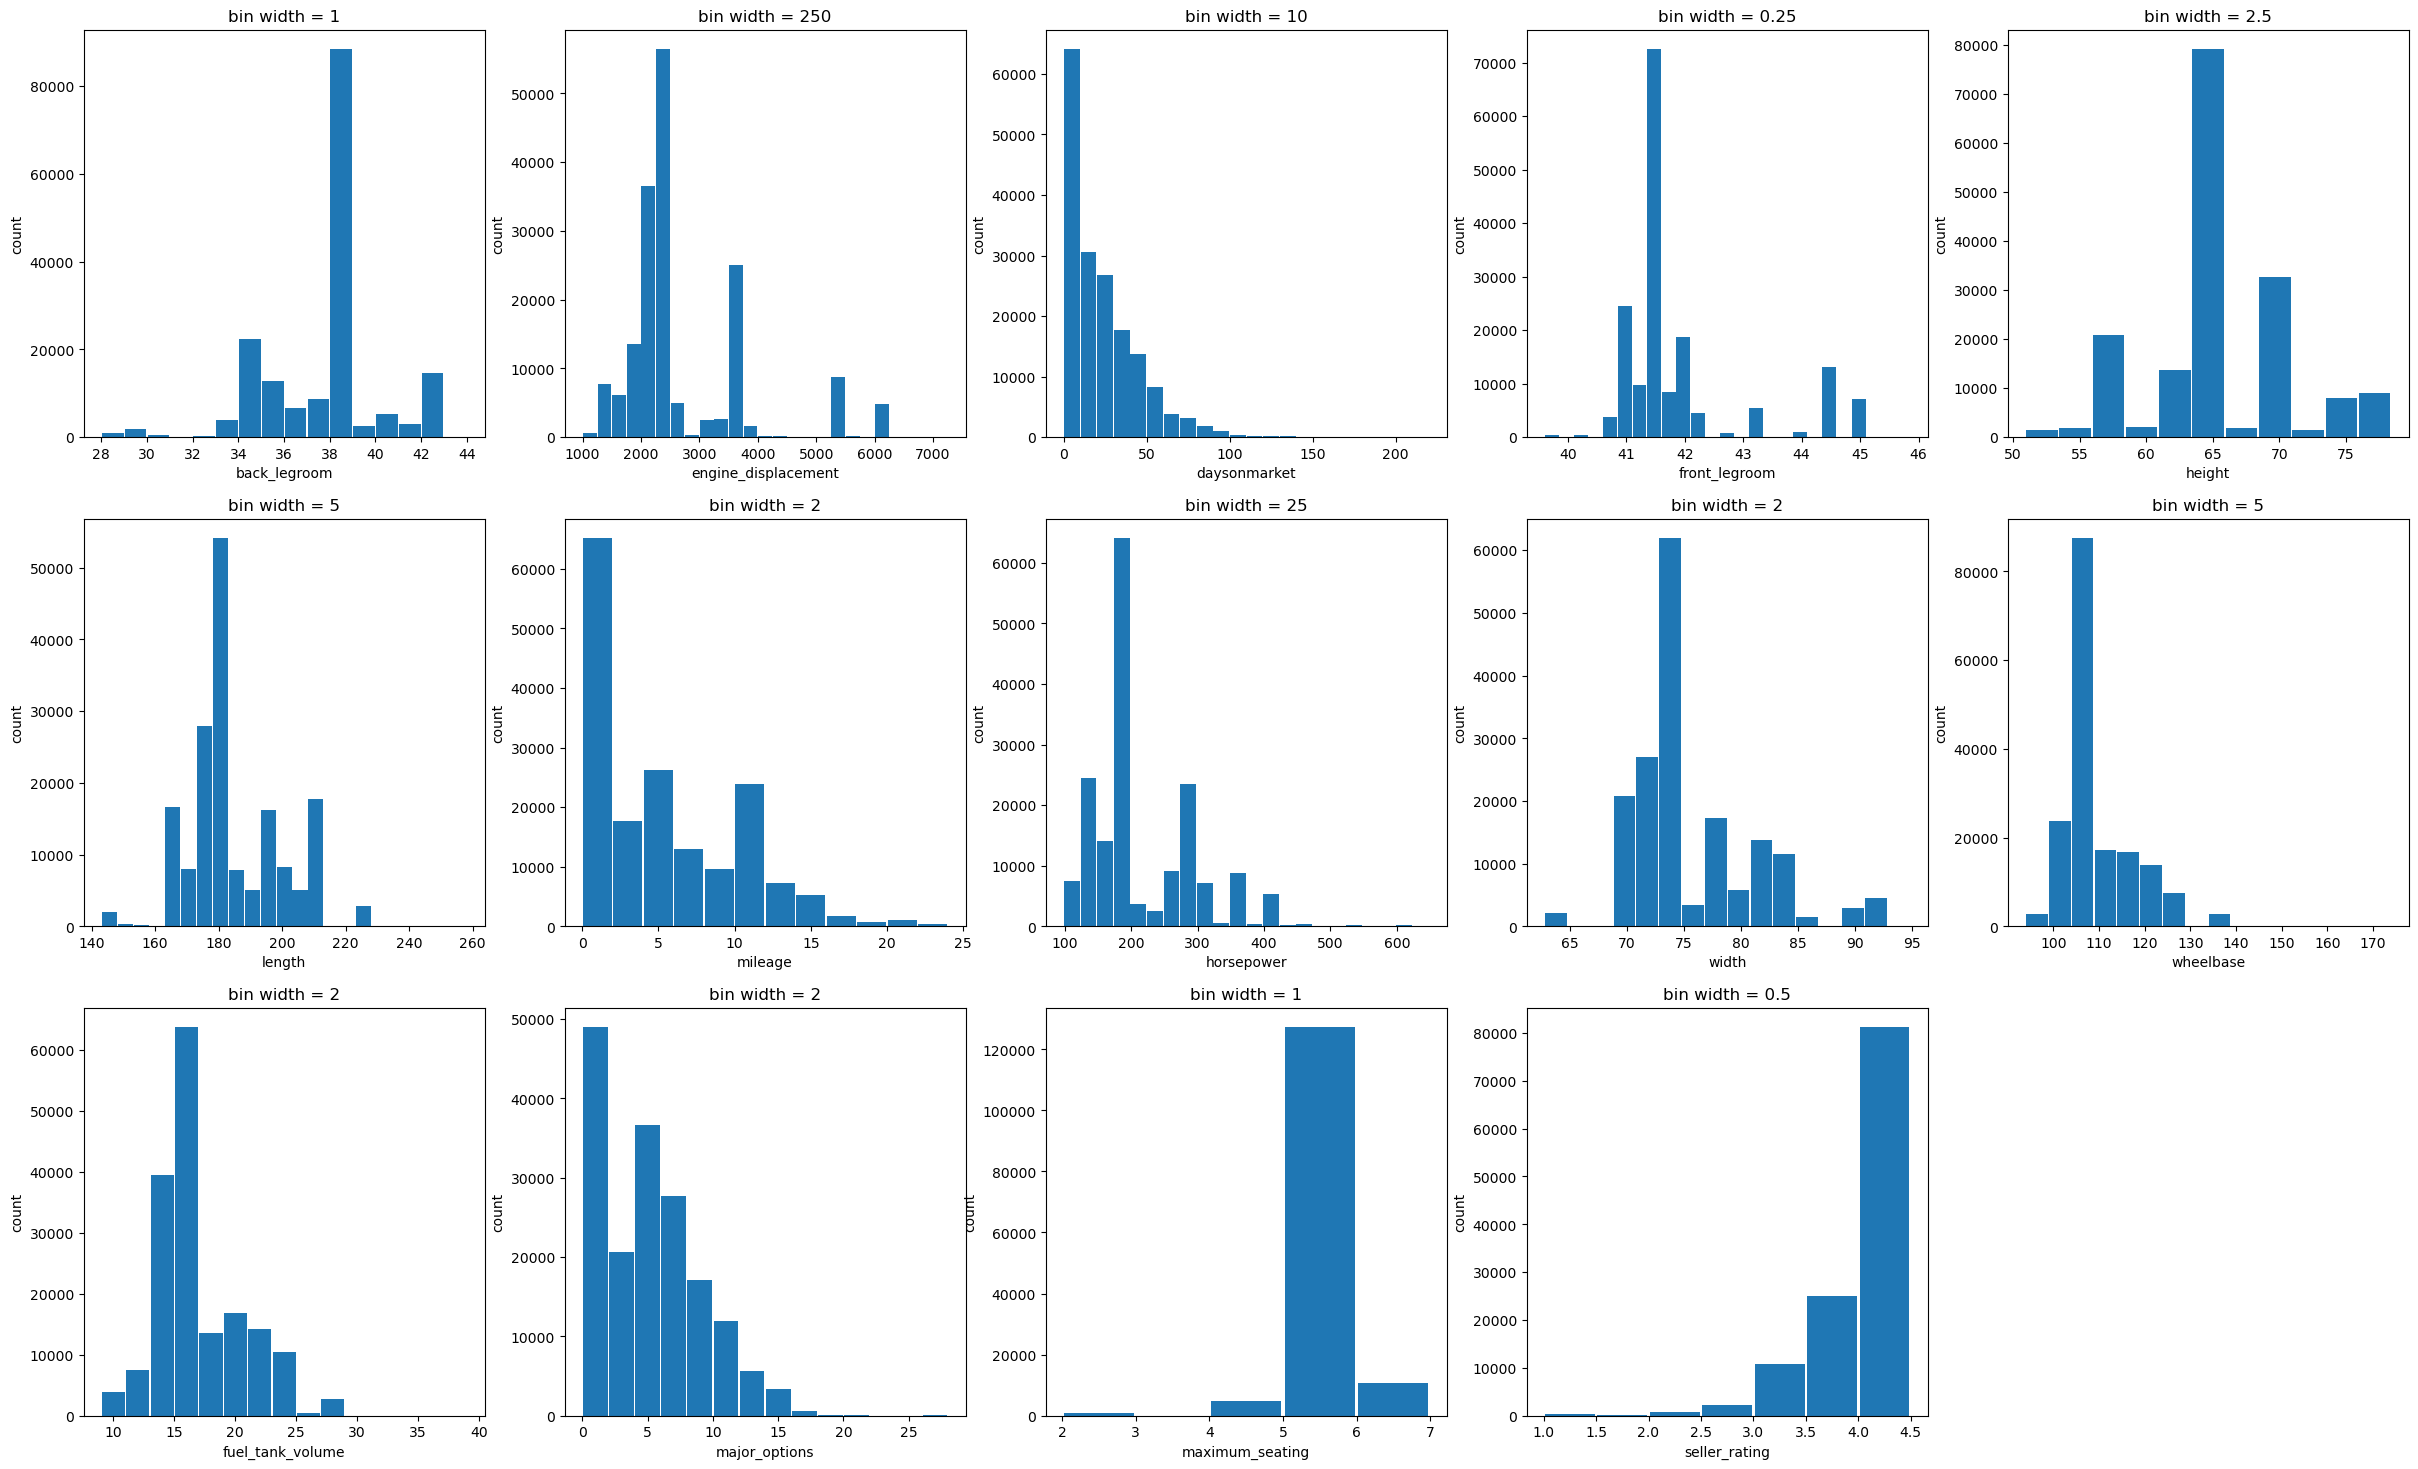

In [24]:
fig, axs = plt.subplots(3, 5, figsize = (30, 18))
#fig.suptitle("Histogram plots")

# Numerical features: ['back_legroom', 'engine_displacement', 'daysonmarket', 'front_legroom',
# 'fuel_tank_volume', 'height', 'horsepower', 'major_options', 'length', 'maximum_seating', 'mileage',
# 'seller_rating', 'wheelbase', 'width']

axs[-1, -1].axis("off")

values = used_cars_features["back_legroom"].to_numpy()
axs[0, 0].hist(values, bins = np.arange(np.min(values), np.max(values), 1), rwidth = 0.95)
axs[0, 0].set(xlabel = "back_legroom", ylabel = "count")
axs[0, 0].set_title("bin width = 1")

values = used_cars_features["engine_displacement"].to_numpy()
axs[0, 1].hist(values, bins = np.arange(np.min(values), np.max(values), 250), rwidth = 0.95)
axs[0, 1].set(xlabel = "engine_displacement", ylabel = "count")
axs[0, 1].set_title("bin width = 250")

values = used_cars_features["daysonmarket"].to_numpy()
axs[0, 2].hist(values, bins = np.arange(np.min(values), np.max(values), 10), rwidth = 0.95)
axs[0, 2].set(xlabel = "daysonmarket", ylabel = "count")
axs[0, 2].set_title("bin width = 10")

# values = np.log(values + 1)
# axs[-1, -1].hist(values, bins = np.arange(np.min(values), np.max(values), 0.25), rwidth = 0.95)
# axs[-1, -1].set(xlabel = "daysonmarket", ylabel = "count")
# axs[-1, -1].set_title(f"bin width = 0.25")

values = used_cars_features["front_legroom"].to_numpy()
axs[0, 3].hist(values, bins = np.arange(np.min(values), np.max(values), 0.25), rwidth = 0.95)
axs[0, 3].set(xlabel = "front_legroom", ylabel = "count")
axs[0, 3].set_title("bin width = 0.25")

values = used_cars_features["height"].to_numpy()
axs[0, 4].hist(values, bins = np.arange(np.min(values), np.max(values), 2.5), rwidth = 0.95)
axs[0, 4].set(xlabel = "height", ylabel = "count")
axs[0, 4].set_title("bin width = 2.5")

values = used_cars_features["length"].to_numpy()
axs[1, 0].hist(values, bins = np.arange(np.min(values), np.max(values), 5), rwidth = 0.95)
axs[1, 0].set(xlabel = "length", ylabel = "count")
axs[1, 0].set_title("bin width = 5")

values = used_cars_features["mileage"].to_numpy()
axs[1, 1].hist(values, bins = np.arange(np.min(values), np.max(values), 2), rwidth = 0.95)
axs[1, 1].set(xlabel = "mileage", ylabel = "count")
axs[1, 1].set_title("bin width = 2")

values = used_cars_features["horsepower"].to_numpy()
axs[1, 2].hist(values, bins = np.arange(np.min(values), np.max(values), 25), rwidth = 0.95)
axs[1, 2].set(xlabel = "horsepower", ylabel = "count")
axs[1, 2].set_title("bin width = 25")

values = used_cars_features["width"].to_numpy()
axs[1, 3].hist(values, bins = np.arange(np.min(values), np.max(values), 2), rwidth = 0.95)
axs[1, 3].set(xlabel = "width", ylabel = "count")
axs[1, 3].set_title("bin width = 2")

values = used_cars_features["wheelbase"].to_numpy()
axs[1, 4].hist(values, bins = np.arange(np.min(values), np.max(values), 5), rwidth = 0.95)
axs[1, 4].set(xlabel = "wheelbase", ylabel = "count")
axs[1, 4].set_title("bin width = 5")

values = used_cars_features["fuel_tank_volume"].to_numpy()
axs[2, 0].hist(values, bins = np.arange(np.min(values), np.max(values), 2), rwidth = 0.95)
axs[2, 0].set(xlabel = "fuel_tank_volume", ylabel = "count")
axs[2, 0].set_title("bin width = 2")

values = used_cars_features["major_options"].to_numpy()
axs[2, 1].hist(values, bins = np.arange(np.min(values), np.max(values), 2), rwidth = 0.95)
axs[2, 1].set(xlabel = "major_options", ylabel = "count")
axs[2, 1].set_title("bin width = 2")

values = used_cars_features["maximum_seating"].to_numpy()
axs[2, 2].hist(values, bins = np.arange(np.min(values), np.max(values), 1), rwidth = 0.95)
axs[2, 2].set(xlabel = "maximum_seating", ylabel = "count")
axs[2, 2].set_title("bin width = 1")

values = used_cars_features["seller_rating"].to_numpy()
axs[2, 3].hist(values, bins = np.arange(np.min(values), np.max(values), 0.5), rwidth = 0.95)
axs[2, 3].set(xlabel = "seller_rating", ylabel = "count")
axs[2, 3].set_title("bin width = 0.5");

# plt.savefig('hist_plots.png', format='png', dpi=800)

## 4.2 Side by side bar plots of categorical features

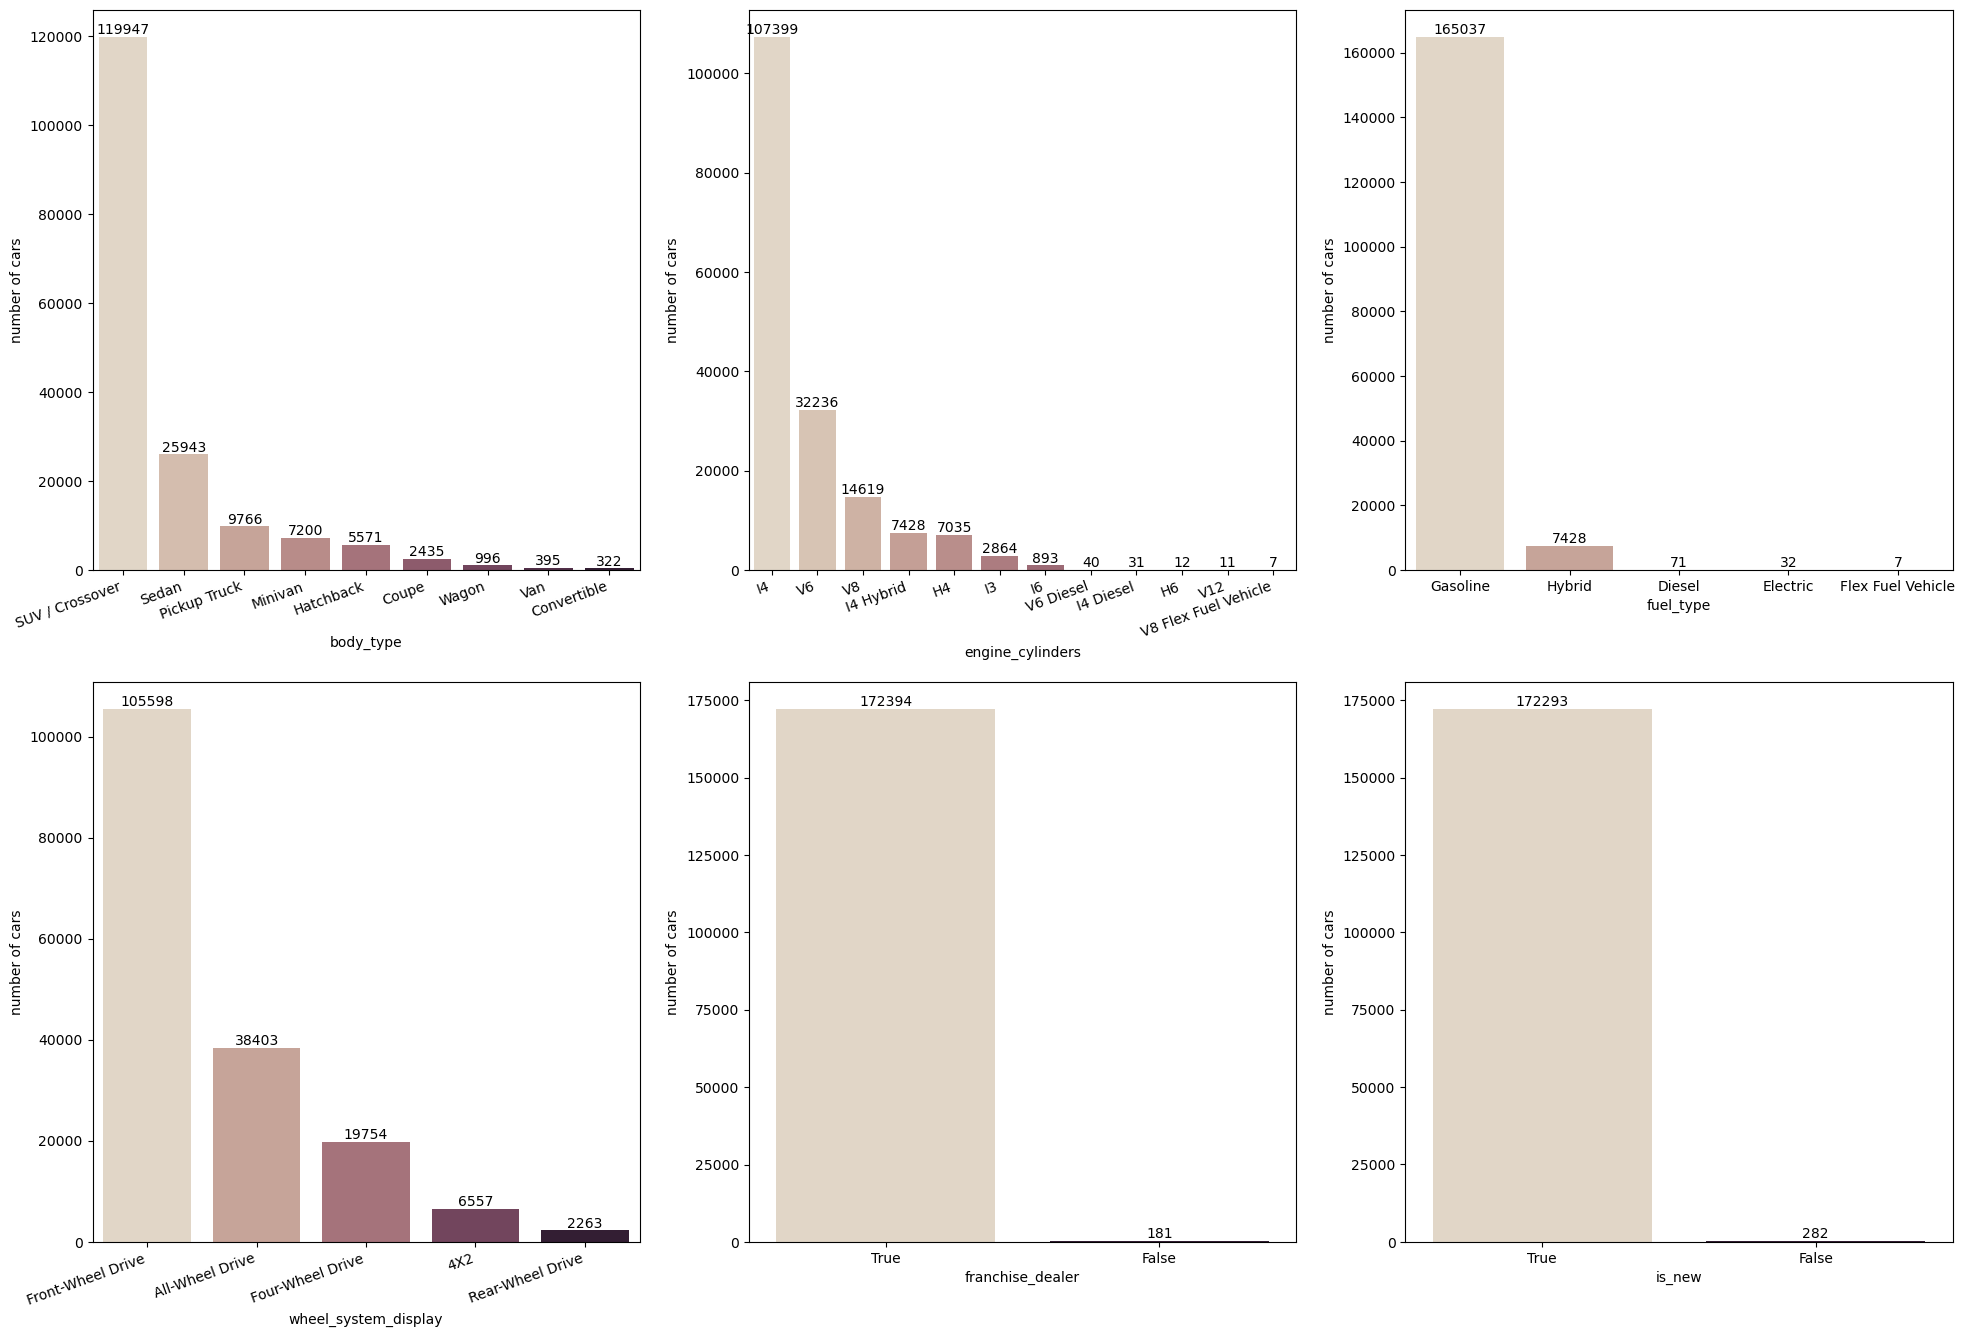

In [25]:
# Categorical features: ['body_type', 'city', 'engine_cylinders', 'exterior_color', 'franchise_make', 'fuel_type',
# 'interior_color', 'listing_color', 'make_name', 'model_name', 'transmission_display',
# 'trim_name', 'wheel_system_display'] -- 13

# Boolean features: ['franchise_dealer', 'is_new'] -- 2

cat_features = ['body_type', 'city', 'engine_cylinders', 'exterior_color', 'franchise_make', 'fuel_type',
  'interior_color', 'listing_color', 'make_name', 'model_name', 'transmission_display',
  'trim_name', 'wheel_system_display']

# for col in cat_features:
#   print(col, used_cars_features[col].nunique())

fig, axs = plt.subplots(2, 3, figsize = (24, 16))
#fig.suptitle("Side-by-Side bar plots")

sns.countplot(ax = axs[0, 0], x = "body_type", palette = "ch:.25", data = used_cars_features,\
              order = used_cars_features["body_type"].value_counts().index)
axs[0, 0].bar_label(axs[0, 0].containers[0])
axs[0, 0].set(xlabel = "body_type", ylabel = "number of cars")
axs[0, 0].set_xticks(axs[0, 0].get_xticks(), axs[0, 0].get_xticklabels(), rotation=20, ha='right')

sns.countplot(ax = axs[0, 1], x = "engine_cylinders", palette = "ch:.25", data = used_cars_features,\
              order = used_cars_features["engine_cylinders"].value_counts().index)
axs[0, 1].bar_label(axs[0, 1].containers[0])
axs[0, 1].set(xlabel = "engine_cylinders", ylabel = "number of cars")
axs[0, 1].set_xticks(axs[0, 1].get_xticks(), axs[0, 1].get_xticklabels(), rotation=20, ha='right')

sns.countplot(ax = axs[0, 2], x = "fuel_type", palette = "ch:.25", data = used_cars_features,\
              order = used_cars_features["fuel_type"].value_counts().index)
axs[0, 2].bar_label(axs[0, 2].containers[0])
axs[0, 2].set(xlabel = "fuel_type", ylabel = "number of cars")

sns.countplot(ax = axs[1, 0], x = "wheel_system_display", palette = "ch:.25", data = used_cars_features,\
              order = used_cars_features["wheel_system_display"].value_counts().index)
axs[1, 0].bar_label(axs[1, 0].containers[0])
axs[1, 0].set(xlabel = "wheel_system_display", ylabel = "number of cars")
axs[1, 0].set_xticks(axs[1, 0].get_xticks(), axs[1, 0].get_xticklabels(), rotation=20, ha='right')

sns.countplot(ax = axs[1, 1], x = "franchise_dealer", palette = "ch:.25", data = used_cars_features,\
              order = used_cars_features["franchise_dealer"].value_counts().index)
axs[1, 1].bar_label(axs[1, 1].containers[0])
axs[1, 1].set(xlabel = "franchise_dealer", ylabel = "number of cars")

sns.countplot(ax = axs[1, 2], x = "is_new", palette = "ch:.25", data = used_cars_features,\
              order = used_cars_features["is_new"].value_counts().index)
axs[1, 2].bar_label(axs[1, 2].containers[0])
axs[1, 2].set(xlabel = "is_new", ylabel = "number of cars");

# plt.savefig('side_by_side_plots.png', format='png', dpi=800)

## 4.3 Distribution of the target variable **price**

In [26]:
# Brief information about the target 'price'
used_cars_price['price'].describe()

count    1.725750e+05
mean     3.757153e+04
std      1.880954e+04
min      1.010800e+04
25%      2.514000e+04
50%      3.219300e+04
75%      4.462500e+04
max      1.116711e+06
Name: price, dtype: float64

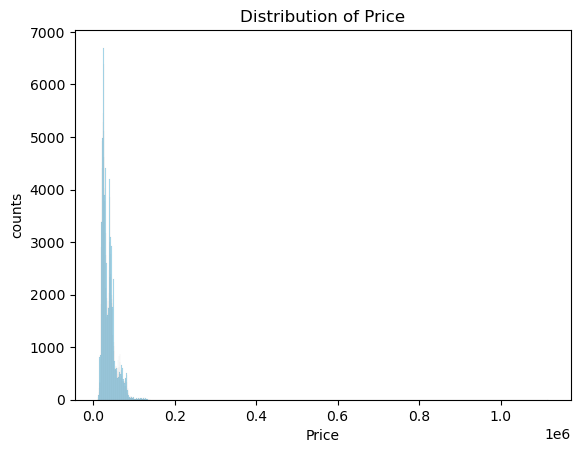

In [27]:
price_data = used_cars_price['price']

# plot the distribution of the target variable 'price'
sns.histplot(price_data, kde=False, color='skyblue', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('counts')
plt.title('Distribution of Price')
plt.show()

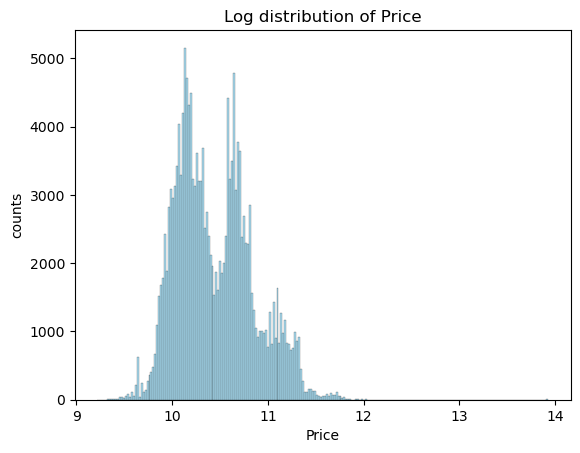

In [28]:
price_data = used_cars_price['price']

# plot the distribution of the target variable 'price'
sns.histplot(np.log(price_data), kde=False, color='skyblue', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('counts')
plt.title('Log distribution of Price')
plt.show()

## 4.4 Scatter plots of numerical features

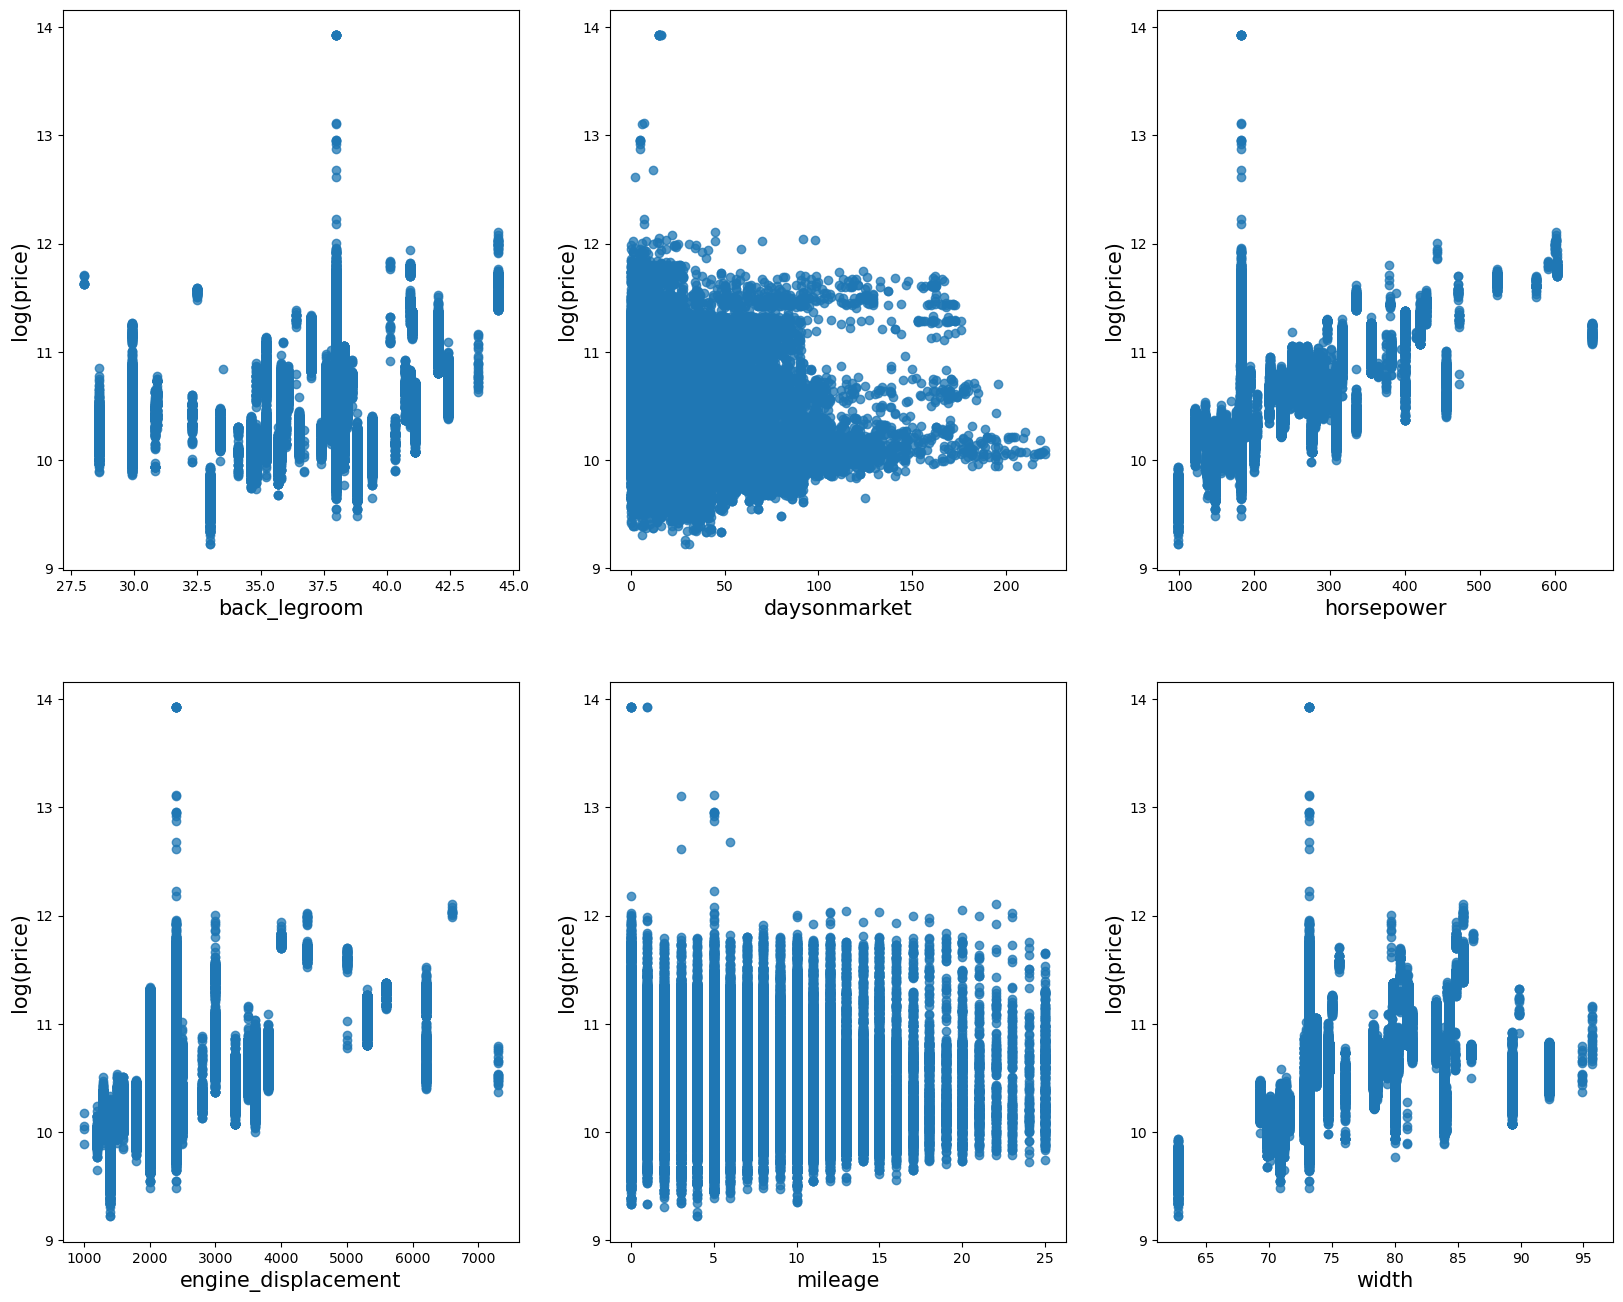

In [29]:
# Numerical features: ['back_legroom', 'engine_displacement', 'daysonmarket', 'front_legroom',
# 'fuel_tank_volume', 'height', 'horsepower', 'major_options', 'length', 'maximum_seating', 'mileage',
# 'seller_rating', 'wheelbase', 'width']

fig, axs = plt.subplots(2, 3, figsize = (20, 16))

# scatter subplot for the 'citympg' feature
axs[0, 0].scatter(used_cars_features["back_legroom"].to_numpy(), np.log(used_cars_price.to_numpy()), alpha = 0.75)
axs[0, 0].set_xlabel(xlabel = "back_legroom", fontsize = 15)
axs[0, 0].set_ylabel(ylabel = "log(price)", fontsize = 15)

axs[0, 1].scatter(used_cars_features["daysonmarket"].to_numpy(), np.log(used_cars_price.to_numpy()), alpha = 0.75)
axs[0, 1].set_xlabel(xlabel = "daysonmarket", fontsize = 15)
axs[0, 1].set_ylabel(ylabel = "log(price)", fontsize = 15)

axs[0, 2].scatter(used_cars_features["horsepower"].to_numpy(), np.log(used_cars_price.to_numpy()), alpha = 0.75)
axs[0, 2].set_xlabel(xlabel = "horsepower", fontsize = 15)
axs[0, 2].set_ylabel(ylabel = "log(price)", fontsize = 15)

axs[1, 0].scatter(used_cars_features["engine_displacement"].to_numpy(), np.log(used_cars_price.to_numpy()), alpha = 0.75)
axs[1, 0].set_xlabel(xlabel = "engine_displacement", fontsize = 15)
axs[1, 0].set_ylabel(ylabel = "log(price)", fontsize = 15)

axs[1, 1].scatter(used_cars_features["mileage"].to_numpy(), np.log(used_cars_price.to_numpy()), alpha = 0.75)
axs[1, 1].set_xlabel(xlabel = "mileage", fontsize = 15)
axs[1, 1].set_ylabel(ylabel = "log(price)", fontsize = 15)

axs[1, 2].scatter(used_cars_features["width"].to_numpy(), np.log(used_cars_price.to_numpy()), alpha = 0.75)
axs[1, 2].set_xlabel(xlabel = "width", fontsize = 15)
axs[1, 2].set_ylabel(ylabel = "log(price)", fontsize = 15);

# plt.savefig('scatter_plots.png', format='png', dpi=600)

## 4.5 Box plots of categorical features

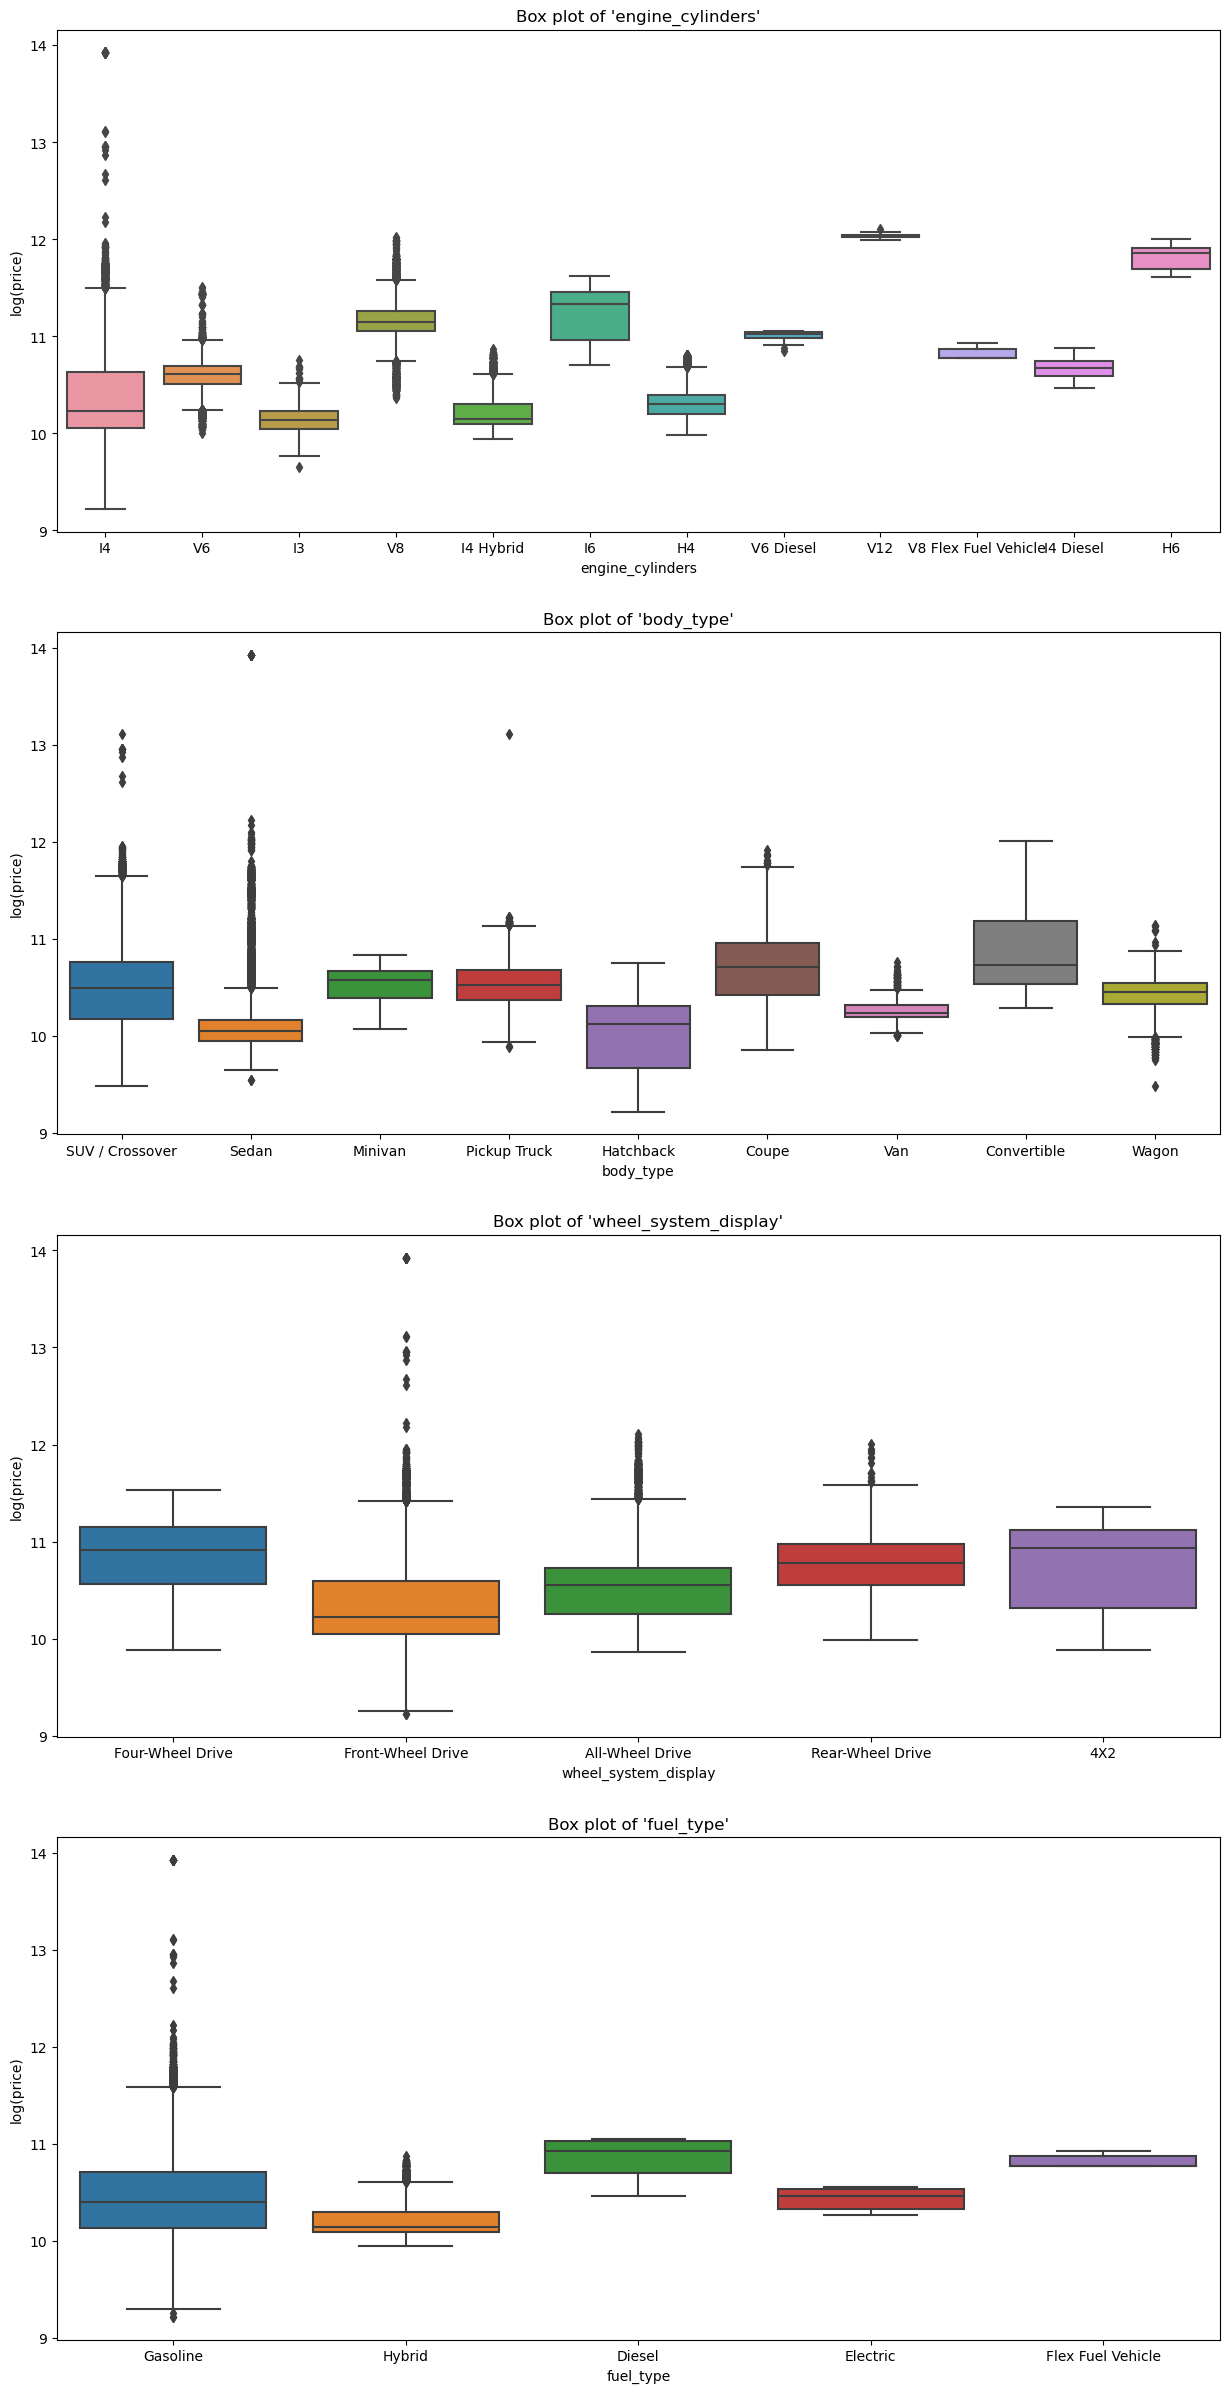

In [30]:
fig, axs = plt.subplots(4, 1, figsize = (15, 30))

# boxplot for engine_cylinders
sns.boxplot(x = used_cars_features['engine_cylinders'], y = np.log(used_cars_price['price']), ax = axs[0])
axs[0].set_title("Box plot of 'engine_cylinders'")
axs[0].set_xlabel('engine_cylinders')
axs[0].set_ylabel('log(price)')

# boxplot for body_type
sns.boxplot(x = used_cars_features['body_type'], y = np.log(used_cars_price['price']), ax = axs[1])
axs[1].set_title("Box plot of 'body_type'")
axs[1].set_xlabel('body_type')
axs[1].set_ylabel('log(price)')

# boxplot for wheel_system_display
sns.boxplot(x = used_cars_features['wheel_system_display'], y = np.log(used_cars_price['price']), ax = axs[2])
axs[2].set_title("Box plot of 'wheel_system_display'")
axs[2].set_xlabel('wheel_system_display')
axs[2].set_ylabel('log(price)')

# boxplot for fuel_type
sns.boxplot(x = used_cars_features['fuel_type'], y = np.log(used_cars_price['price']), ax = axs[3])
axs[3].set_title("Box plot of 'fuel_type'")
axs[3].set_xlabel('fuel_type')
axs[3].set_ylabel('log(price)')

plt.show()

## 4.6 Box plots of numerical features

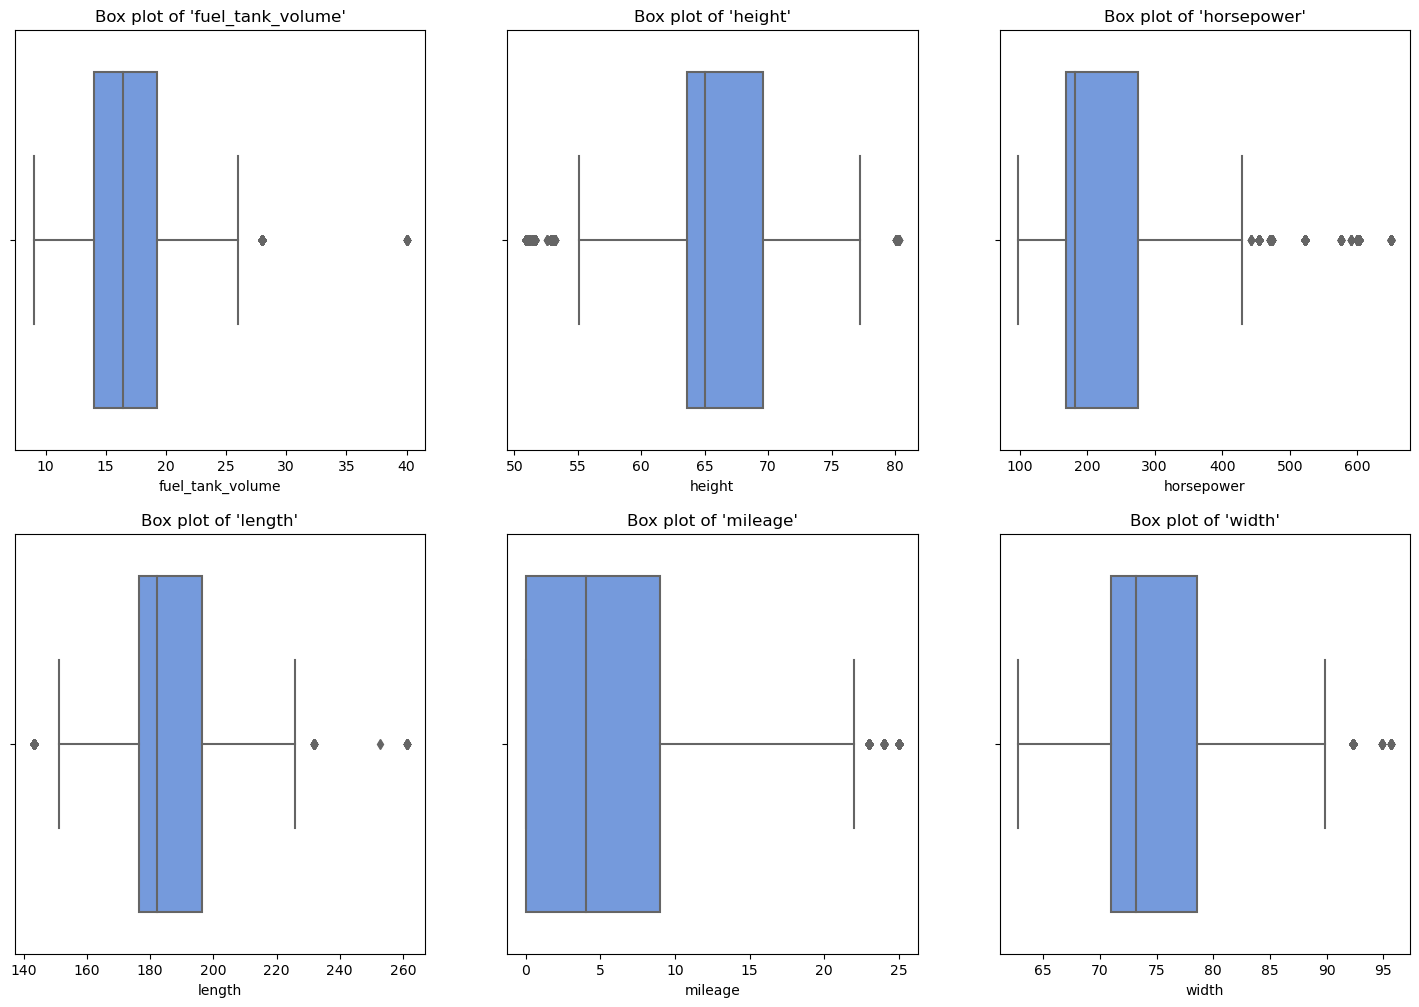

In [31]:
fig, axs = plt.subplots(2, 3, figsize = (18, 12))

numerical_features =  ['fuel_tank_volume', 'height', 'horsepower', 'length', 'mileage', 'width']

for idx, feature in enumerate(numerical_features):
  row = idx//3
  col = idx%3
  # box subplot for the 'price'
  sns.boxplot(ax = axs[row, col], x = feature, data = used_cars_features, color = 'cornflowerblue', palette = None);
  axs[row, col].set_title(f"Box plot of '{feature}'")

## 4.7 Prepare train, validation and test datasets

In [32]:
X = used_cars_features.copy()
y = used_cars_price['price'].copy().to_numpy().reshape(-1, 1)

feature_names = list(X.columns)

q1 = np.percentile(y, 25)
q3 = np.percentile(y, 75)
upper_limit = q3 + 1.5 * (q3 - q1)
lower_limit = q1 - 1.5 * (q3 - q1)

# Use this encoding to split the outliers uniformly across dev and test datasets!!!
y_binary = np.where(y <= upper_limit, 0, 1)

# 60% train, 20% validation, and 20% test dataset
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y_binary)

# Use this encoding to split the outliers uniformly across train and val datasets!!!
y_binary_dev = np.where(y_dev <= upper_limit, 0, 1)

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.25, random_state = 42, stratify = y_binary_dev)

print("Shape of train dataset: ", X_train.shape)
print("Shape of validation dataset: ", X_val.shape)
print("Shape of test dataset: ", X_test.shape)

# log transformation of the target 'price' to reduce the skewness
y_train = np.log(y_train)
y_val = np.log(y_val)
y_test = np.log(y_test)

y_dev = np.log(y_dev)

Shape of train dataset:  (103545, 28)
Shape of validation dataset:  (34515, 28)
Shape of test dataset:  (34515, 28)


## 4.8 Encoding the categorical features

In [33]:
# Encoding the categorical variables
# Categorical features: ['body_type', 'city', 'engine_cylinders', 'exterior_color', 'franchise_make', 'fuel_type',
# 'interior_color', 'listing_color', 'make_name', 'model_name', 'transmission_display',
# 'trim_name', 'wheel_system_display'] -- 13

# Boolean features: ['franchise_dealer', 'is_new'] -- 2
used_cars_features["franchise_dealer"] = used_cars_features["franchise_dealer"].astype(int)
used_cars_features["is_new"] = used_cars_features["is_new"].astype(int)

ohe_features = ["body_type", "wheel_system_display"]
ord_features = ["engine_cylinders", "fuel_type"]

te_features = [
    "city",
    "listing_color",
    "interior_color",
    "make_name",
    "franchise_make",
    "transmission_display",
]

# these features when 'target' encoded show high coefficient of determination with 'price' to be predicted
# this is not an ideal scenario and so these features are encoded using Binary encoding
# Binary encoding is similar to one-hot encoding but with reduced dimensionality
binary_enc_features = ["trim_name", "model_name"]

rem_features = ['body_type', 'engine_cylinders', 'fuel_type', 'wheel_system_display']

# Importance assigned based on usually observed sale prices
ordinal_enc = OrdinalEncoder(categories = [[ "Gasoline", "Diesel", "Flex Fuel Vehicle", "Hybrid", "Electric"]])
X_train["ord_fuel_type"] = ordinal_enc.fit_transform(X_train["fuel_type"].to_numpy().reshape(-1, 1))
X_train = X_train.drop("fuel_type", axis = 1)
X_val["ord_fuel_type"] = ordinal_enc.transform(X_val["fuel_type"].to_numpy().reshape(-1, 1))
X_val = X_val.drop("fuel_type", axis = 1)
X_test["ord_fuel_type"] = ordinal_enc.transform(X_test["fuel_type"].to_numpy().reshape(-1, 1))
X_test = X_test.drop("fuel_type", axis = 1)
X_dev["ord_fuel_type"] = ordinal_enc.transform(X_dev["fuel_type"].to_numpy().reshape(-1, 1))
X_dev = X_dev.drop("fuel_type", axis = 1)

# H6, V12 are additional categories
ordinal_enc = OrdinalEncoder(categories = [['I3', 'H4', 'I4', 'I4 Diesel', 'H6', 'I4 Hybrid', 'I6', 
                                            'V6', 'V6 Diesel', 'V8', 'V8 Flex Fuel Vehicle', 'V12']])
X_train["ord_engine_cylinders"] = ordinal_enc.fit_transform(X_train["engine_cylinders"].to_numpy().reshape(-1, 1))
X_train = X_train.drop("engine_cylinders", axis = 1)
X_val["ord_engine_cylinders"] = ordinal_enc.transform(X_val["engine_cylinders"].to_numpy().reshape(-1, 1))
X_val = X_val.drop("engine_cylinders", axis = 1)
X_test["ord_engine_cylinders"] = ordinal_enc.transform(X_test["engine_cylinders"].to_numpy().reshape(-1, 1))
X_test = X_test.drop("engine_cylinders", axis = 1)
X_dev["ord_engine_cylinders"] = ordinal_enc.transform(X_dev["engine_cylinders"].to_numpy().reshape(-1, 1))
X_dev = X_dev.drop("engine_cylinders", axis = 1)

X_train = pd.get_dummies(X_train, columns = ohe_features)
X_val = pd.get_dummies(X_val, columns = ohe_features)
X_test = pd.get_dummies(X_test, columns = ohe_features)
X_dev = pd.get_dummies(X_dev, columns = ohe_features)

for feat in te_features:
  te = TargetEncoder(cols = [feat], handle_missing = 'value', handle_unknown = 'value').fit(X_train, y_train)
  X_train = te.transform(X_train)
  X_val = te.transform(X_val)
  X_test = te.transform(X_test)
  X_dev = te.transform(X_dev)

binary = BinaryEncoder(cols = binary_enc_features, return_df = True, handle_missing = 'value', handle_unknown = 'value')
X_train = binary.fit_transform(X_train)
X_val = binary.transform(X_val)
X_test = binary.transform(X_test)
X_dev = binary.transform(X_dev)

X_train.head()

,back_legroom,city,daysonmarket,engine_displacement,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,height,horsepower,...,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,body_type_Van,body_type_Wagon,wheel_system_display_4X2,wheel_system_display_All-Wheel Drive,wheel_system_display_Four-Wheel Drive,wheel_system_display_Front-Wheel Drive,wheel_system_display_Rear-Wheel Drive
171976,34.8,10.375320,3,1800.0,True,10.124638,42.0,13.2,56.5,139.0,...,0,0,1,0,0,0,0,0,1,0
24327,38.0,10.359323,15,2400.0,True,11.016923,41.5,16.4,65.0,182.0,...,0,1,0,0,0,0,0,0,1,0
161987,34.8,10.363398,106,1800.0,True,10.124638,42.0,13.2,56.5,139.0,...,0,0,1,0,0,0,0,0,1,0
140298,38.2,10.180128,31,2400.0,True,10.258880,41.5,16.4,65.0,181.0,...,0,1,0,0,0,0,0,0,1,0
6661,42.0,10.800095,40,6200.0,True,10.553244,44.5,24.0,75.9,420.0,...,0,1,0,0,0,0,0,1,0,0


In [34]:
# Plots to understand the issues with target encoding of certain features
# fig, axs = plt.subplots(5, 2, figsize = (16, 30))

# for idx, val in enumerate(te_features):
#     i = idx//2
#     j = idx%2
    
#     axs[i][j].scatter(X_train[val], y_train)
#     axs[i][j].set(xlabel = f"target encoded '{val}'", ylabel = "'price'")
#     axs[i][j].set_title(f"R2 score = {round(r2_score(y_train, X_train[val]), 4)}")

In [35]:
# features in the dataset after encoding
X_train.columns

Index(['back_legroom', 'city', 'daysonmarket', 'engine_displacement',
       'franchise_dealer', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'height', 'horsepower', 'interior_color', 'is_new',
       'length', 'listing_color', 'major_options', 'make_name',
       'maximum_seating', 'mileage', 'model_name_0', 'model_name_1',
       'model_name_2', 'model_name_3', 'model_name_4', 'model_name_5',
       'model_name_6', 'model_name_7', 'seller_rating', 'transmission_display',
       'trim_name_0', 'trim_name_1', 'trim_name_2', 'trim_name_3',
       'trim_name_4', 'trim_name_5', 'trim_name_6', 'trim_name_7',
       'trim_name_8', 'wheelbase', 'width', 'ord_fuel_type',
       'ord_engine_cylinders', 'body_type_Convertible', 'body_type_Coupe',
       'body_type_Hatchback', 'body_type_Minivan', 'body_type_Pickup Truck',
       'body_type_SUV / Crossover', 'body_type_Sedan', 'body_type_Van',
       'body_type_Wagon', 'wheel_system_display_4X2',
       'wheel_system_display_All

## 4.9 Correlation matrix

Features to be dropped:  ['make_name', 'wheelbase']


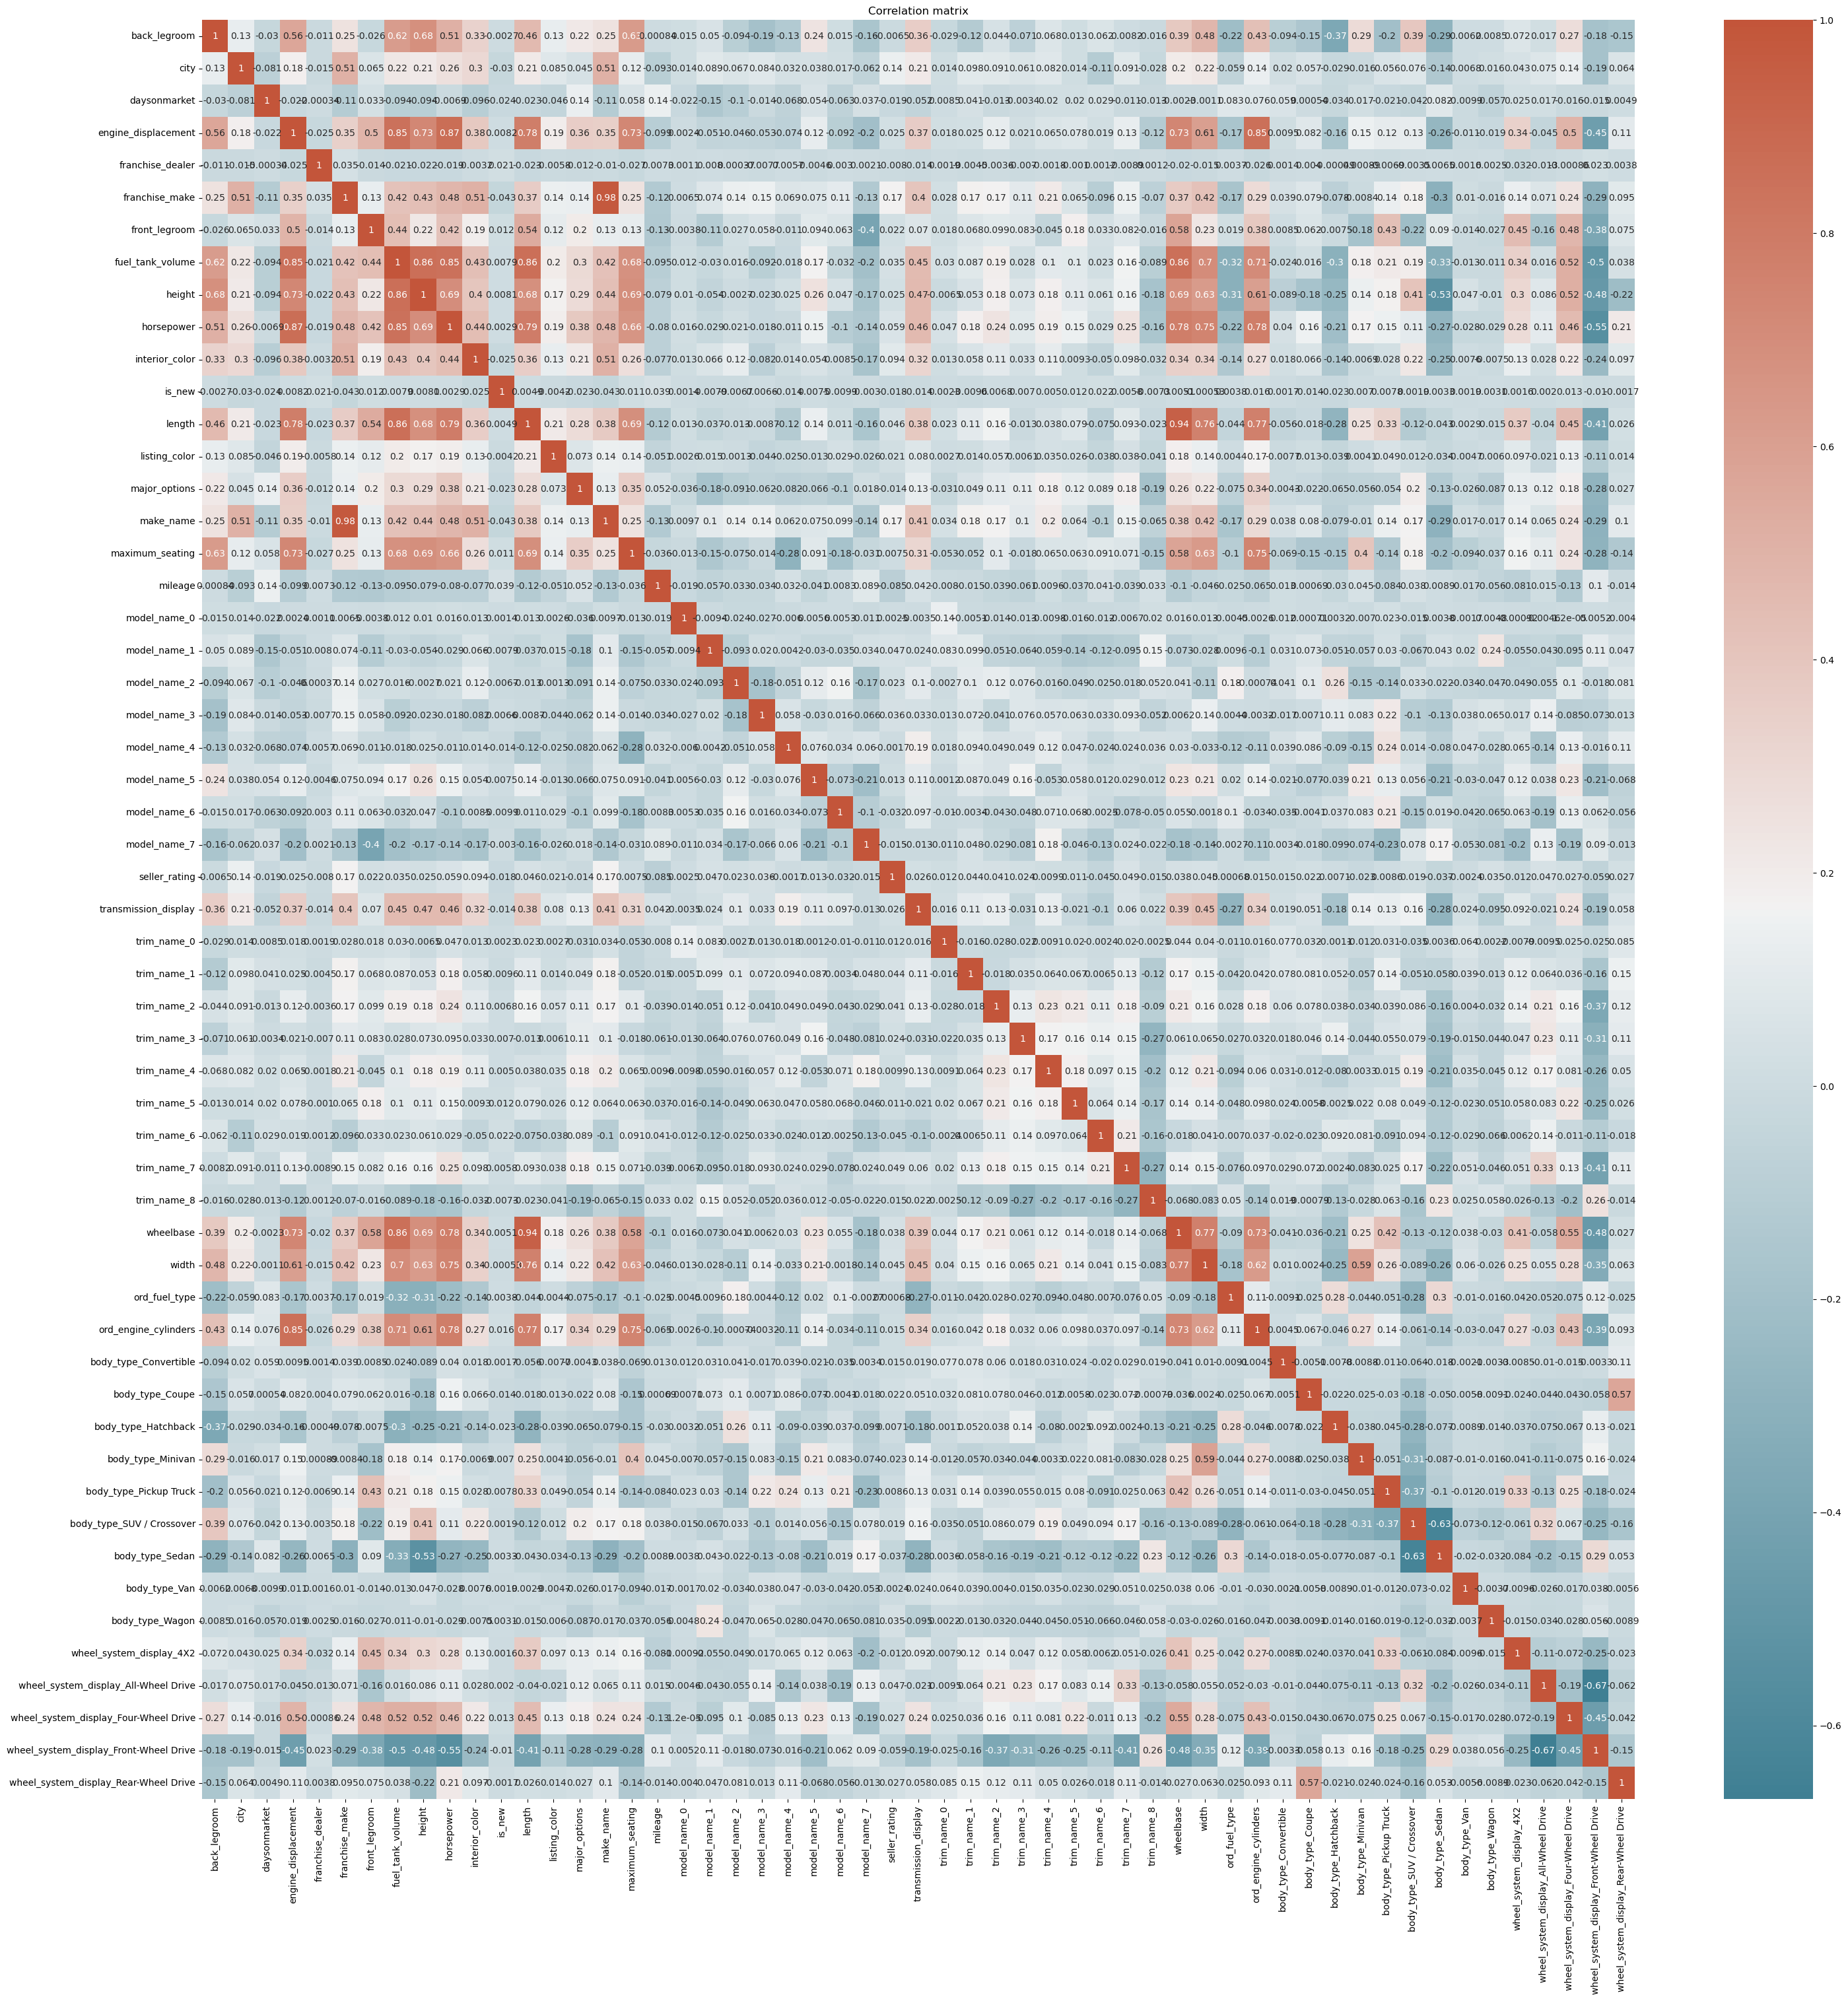

In [36]:
# compute the correlation matrix
corr_matrix = X_train.corr()

plt.figure(figsize = (35, 35))
sns.heatmap(corr_matrix, cmap = sns.diverging_palette(220, 20, as_cmap=True), annot = True)
plt.title("Correlation matrix");
# plt.savefig('corr_matrix.png', format='png', dpi=600)

# compute the absolute correlation matrix
corr_matrix_abs = X_train.corr().abs()

# select upper triangle of the matrix
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k = 1).astype(bool))

# select one of the features with high correlation 
to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

print("Features to be dropped: ", to_drop)

# drop these features 
X_train.drop(to_drop, axis = 1, inplace=True)
X_val.drop(to_drop, axis = 1, inplace=True)
X_test.drop(to_drop, axis = 1, inplace=True)
X_dev.drop(to_drop, axis = 1, inplace=True)

# **5. Models and Prediction**

In [37]:
# Scale the features in the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)      # Fit and transform scalar on train dataset
X_val_scaled = scaler.transform(X_val)              # Transform validation dataset
X_test_scaled = scaler.transform(X_test)            # Transform test dataset

X_dev_scaled = scaler.transform(X_dev)              # Transform dev dataset

In [38]:
feature_names = list(X_train.columns)

In [39]:
# Inverse the log transformation for computing the error metrics
y_dev_orig = np.exp(y_dev)
y_val_orig = np.exp(y_val)
y_test_orig = np.exp(y_test)

## 5.1 Baseline model: Linear regression

In [40]:
X_train_linear = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])
X_val_linear = np.hstack([np.ones((X_val_scaled.shape[0], 1)), X_val_scaled])
X_test_linear = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])

X_dev_linear = np.hstack([np.ones((X_dev_scaled.shape[0], 1)), X_dev_scaled])

In [41]:
class LinearRegressionCustom():
    '''
    Linear regression model with L2-regularization (i.e. ridge regression).

    Attributes
    ----------
    alpha: regularization parameter
    w: (n x 1) weight vector
    '''
    
    def __init__(self, alpha = 0):
        self.alpha = alpha
        self.w = None

    def train(self, X, y):
        '''Trains model using ridge regression closed-form solution 
        (sets w to its optimal value).
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        None
        '''
        ### Your code here
        if type(y) is not np.ndarray:
            y = y.to_numpy()
        
        xT_x = (X.T) @ X
        I = np.identity(xT_x.shape[0])
        
        self.w = np.linalg.solve(xT_x + self.alpha * I, (X.T) @ y)       
        return
        
    def predict(self, X):
        '''Predicts on X using trained model.
        
        Parameters
        ----------
        X : (m x n) feature matrix
        
        Returns
        -------
        y_pred: (m x 1) prediction vector
        '''
        ### Your code here
        y_pred = X @ self.w
        return y_pred  

In [42]:
# Create and fit the model on dev dataset
lr_model = LinearRegressionCustom(alpha = 0)
lr_model.train(X_dev_linear, y_dev)

y_pred_dev_log = lr_model.predict(X_dev_linear)
y_pred_test_log = lr_model.predict(X_test_linear)

y_pred_dev = np.exp(y_pred_dev_log)
y_pred_test = np.exp(y_pred_test_log)

linear_r2_score_dev = r2_score(y_dev, y_pred_dev_log)
linear_r2_score_test = r2_score(y_test, y_pred_test_log)

linear_rmse_test = mean_squared_error(y_test_orig, y_pred_test, squared = False)
linear_mae_test = mean_absolute_error(y_test_orig, y_pred_test)
linear_mape_test = mean_absolute_percentage_error(y_test_orig, y_pred_test)
linear_rmsle_test = mean_squared_log_error(y_test_orig, y_pred_test, squared = False)

print("Linear Regression R2 score on the dev dataset: ", round(linear_r2_score_dev, 4))
print("Linear Regression R2 score on the test dataset: ", round(linear_r2_score_test, 4))

print("Linear Regression RMSE loss on the test dataset: ", round(linear_rmse_test, 4))
print("Linear Regression MAE loss on the test dataset: ", round(linear_mae_test, 4))
print("Linear Regression MAPE loss on the test dataset: ", round(linear_mape_test, 4))
print("Linear Regression RMSLE loss on the test dataset: ", round(linear_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_lr_roc_score = regression_roc_auc_score(y_test_orig, y_pred_test)
print("Linear Regression ranking ability (regression ROC): ", round(test_lr_roc_score, 4))

Linear Regression R2 score on the dev dataset:  0.8171
Linear Regression R2 score on the test dataset:  0.8085
Linear Regression RMSE loss on the test dataset:  14435.3147
Linear Regression MAE loss on the test dataset:  5278.0817
Linear Regression MAPE loss on the test dataset:  0.1305
Linear Regression RMSLE loss on the test dataset:  0.1759
Linear Regression ranking ability (regression ROC):  0.8596


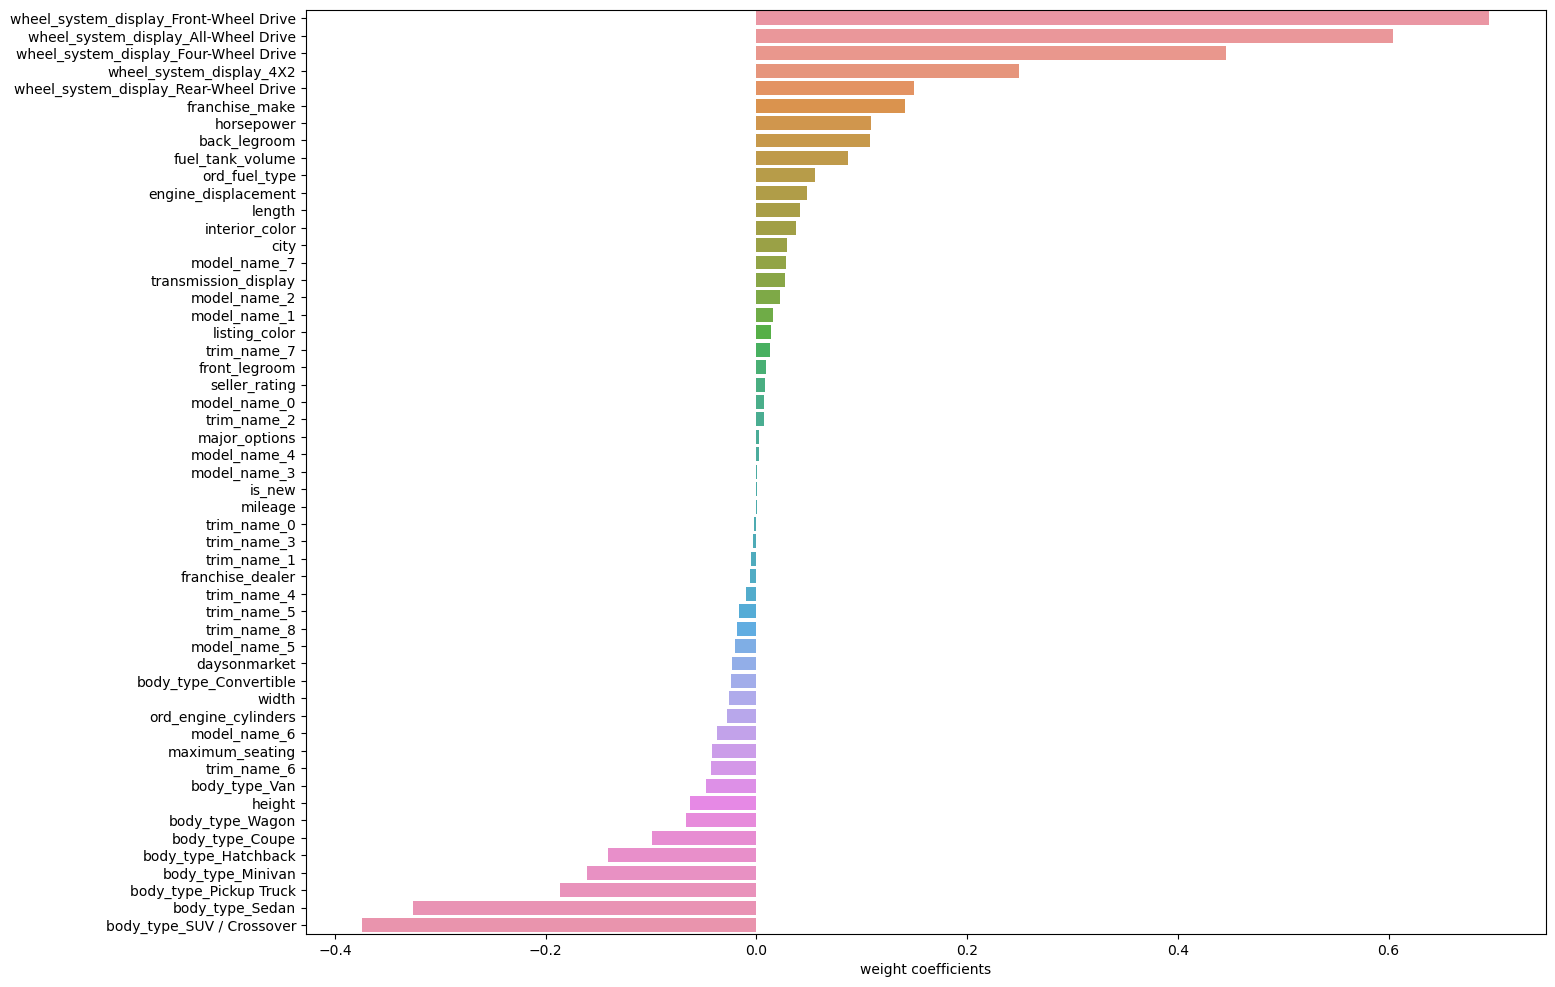

In [43]:
# plot the weight coefficients of each feature
plt.figure(figsize = (16, 12))

# 1st column represents the bias term (not needed here)
feat_imps = zip(feature_names, lr_model.w[1:, 0])
feats, imps = zip(*(sorted(feat_imps, key = lambda x: x[1], reverse=True)))
sns.barplot(y = list(feats), x = list(imps), orient = "h")
plt.xlabel('weight coefficients');

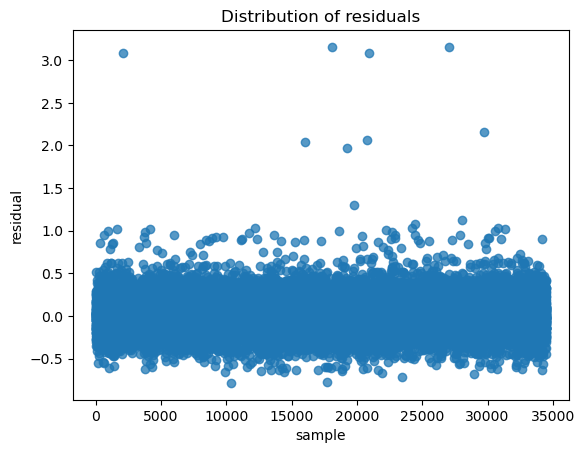

In [44]:
# plot the distribution of errors/residuals
plt.scatter(np.arange(len(y_test)), (y_test - y_pred_test_log), alpha = 0.75)
plt.xlabel('sample')
plt.ylabel('residual')
plt.title('Distribution of residuals')
plt.show()

## 5.2 Elastic Net Regression

### Default Elastic Net Regression

In [54]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

elastic_net = ElasticNet()

# fit the model
elastic_net.fit(X_dev_scaled, y_dev)

# Compute the R2 score for dev and test datasets
y_dev_pred_log = elastic_net.predict(X_dev_scaled)
y_test_pred_log = elastic_net.predict(X_test_scaled)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

dev_eln_r2_score = r2_score(y_dev,y_dev_pred_log)
test_eln_r2_score = r2_score(y_test, y_test_pred_log)

eln_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
eln_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
eln_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
eln_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

print("Elastic net Regression R2 score on the dev dataset: ", round(dev_eln_r2_score, 4))
print("Elastic net Regression R2 score on the test dataset: ", round(test_eln_r2_score, 4))

print("Elastic net Regression RMSE loss on the test dataset: ", round(eln_rmse_test, 4))
print("Elastic net Regression MAE loss on the test dataset: ", round(eln_mae_test, 4))
print("Elastic net Regression MAPE loss on the test dataset: ", round(eln_mape_test, 4))
print("Elastic net Regression RMSLE loss on the test dataset: ", round(eln_rmsle_test, 4))


Elastic net Regression R2 score on the dev dataset:  0.0
Elastic net Regression R2 score on the test dataset:  -0.0001
Elastic net Regression RMSE loss on the test dataset:  21084.9667
Elastic net Regression MAE loss on the test dataset:  12730.0606
Elastic net Regression MAPE loss on the test dataset:  0.3366
Elastic net Regression RMSLE loss on the test dataset:  0.4019


### Hyperparameters Tuning

In [66]:
import warnings
warnings.simplefilter("ignore")

param_grid = {
    'alpha': np.arange(0, 1, 0.1),
    'l1_ratio': [1e-5,1e-4,1e-3, 1e-2, 1e-1, 0.0, 1.0]
}

best_score = -float('inf')
best_hyperparameters = None

for alpha in param_grid['alpha']:
    for l1_ratio in param_grid['l1_ratio']:
            eln_regressor = ElasticNet(alpha = alpha, l1_ratio = l1_ratio)
            eln_regressor.fit(X_train_scaled, y_train)
            y_val_pred = eln_regressor.predict(X_val_scaled)
            val_score = r2_score(y_val, y_val_pred)
            if val_score > best_score:
                best_score = val_score
                best_hyperparameters = {'alpha':alpha, 'l1_ratio':l1_ratio}

best_eln_regressor = ElasticNet(alpha=best_hyperparameters['alpha'], l1_ratio=best_hyperparameters['l1_ratio'])
best_eln_regressor.fit(X_train_scaled, y_train)

y_val_pred = best_eln_regressor.predict(X_val_scaled)
# y_val_pred = y_val_pred.reshape(len(y_val), 1)
val_score = r2_score(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val_orig, y_val_pred)
val_rmse = mean_squared_error(y_val_orig, y_val_pred, squared=False)
# val_dc_roc_score = regression_roc_auc_score(y_val_orig, y_val_pred)

y_test_pred = best_eln_regressor.predict(X_test_scaled)
# y_test_pred = y_test_pred.reshape(len(y_test), 1)
test_score = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test_orig, y_test_pred)
test_rmse = mean_squared_error(y_test_orig, y_test_pred, squared=False)
# test_dc_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)

print("For Decision Tree model, best hyperparameters:", best_hyperparameters)
print("Results on validation set with best hyperparameters:")
print("R2 score:", val_score)
print("MAE score:", val_mae)
print("RMSE score:", val_rmse)
# print("Ranking ability (regression ROC): ", val_dc_roc_score)
print("\nResults on test set with best hyperparameters:")
print("R2 score:", test_score)
print("MAE score:", test_mae)
print("RMSE score:", test_rmse)
# print("Ranking ability (regression ROC): ", test_dc_roc_score)

For Decision Tree model, best hyperparameters: {'alpha': 0.0, 'l1_ratio': 1e-05}
Results on validation set with best hyperparameters:
R2 score: 0.8168827034920347
MAE score: 37416.64363636595
RMSE score: 41141.7255040093

Results on test set with best hyperparameters:
R2 score: 0.8083981501771009
MAE score: 37709.89487898201
RMSE score: 43078.13980641625


<Axes: >

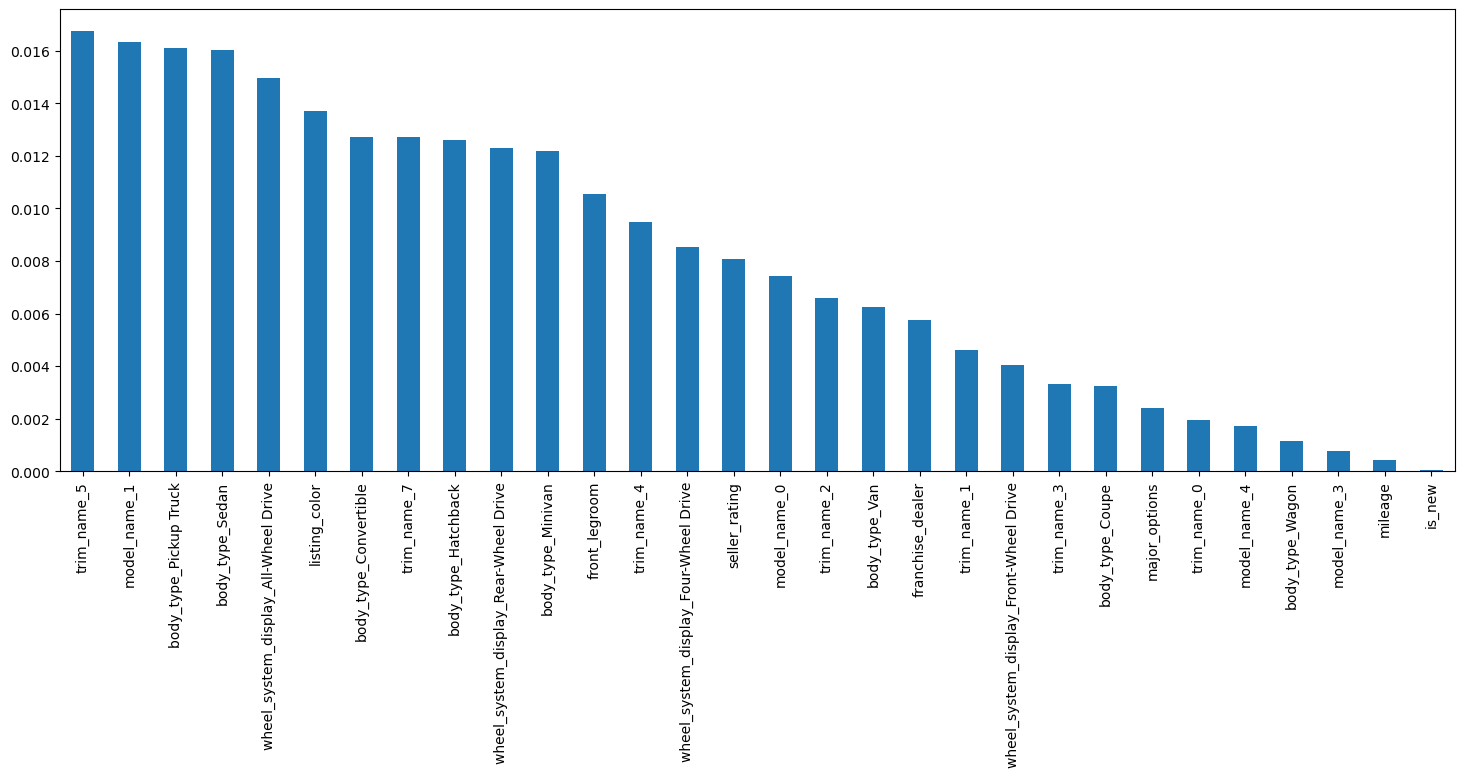

In [70]:
## plot feature importance
feature_importance = pd.Series(index = X_dev.columns, data = np.abs(best_eln_regressor.coef_))

feature_importance.sort_values(ascending=False).tail(30).plot(kind = 'bar', figsize = (18,6))

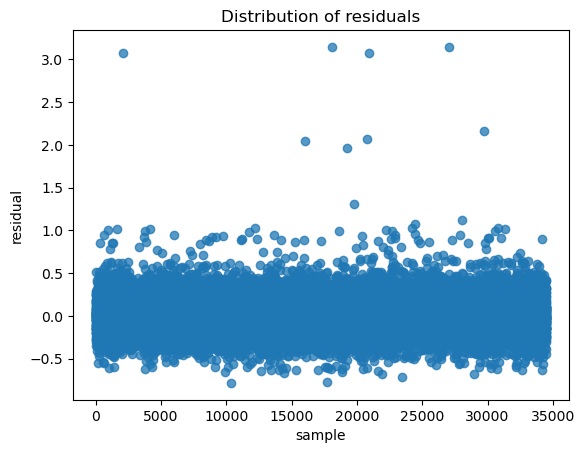

In [68]:
# plot the distribution of errors/residuals
plt.scatter(np.arange(len(y_test)), (y_test - y_test_pred.reshape((len(y_test), 1))), alpha = 0.75)
plt.xlabel('sample')
plt.ylabel('residual')
plt.title('Distribution of residuals')
plt.show()